In [ ]:
from tms_risk.cogmodels.fit_model import build_model, get_data
from tms_risk.cogmodels.utils import plot_prediction, stimulation_order, stimulation_palette
import seaborn as sns
import arviz as az
import os.path as op
import pandas as pd
import matplotlib.pyplot as plt
from bauer.utils.math import softplus_np
import numpy as np
from bauer.models import FlexibleNoiseRiskRegressionModel
from tqdm import tqdm
import pandas as pd

sns.set(font_scale=1.5, style='white', palette=sns.color_palette())


bids_folder = '/data/ds-tmsrisk'

# Some convenience functions
def get_info(model_label, bids_folder='/data/ds-tmsrisk'):

    df = get_data(model_label=model_label, bids_folder=bids_folder)
    model = build_model(df=df, model_label=model_label)
    idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))

    return df, model, idata

conditions = pd.DataFrame([{'stimulation_condition':'vertex'},
                            {'stimulation_condition':'ips'}])

model_label = 'flexible2'

df, model, idata = get_info(model_label)
model.build_estimation_model()

group_curves = model.get_sd_curve(conditions, idata=idata.sel(draw=slice(None, None,25)), x=np.arange(7, 113), variable='both', group=True)
curves = model.get_sd_curve(conditions, idata=idata.sel(draw=slice(None, None,25)), x=np.arange(7, 113), variable='both', group=False)

In [ ]:
prior = model.get_conditionwise_parameters(conditions=conditions, idata=idata.sel(draw=slice(None, None,25)), group=False)
mean_priors = prior.loc[['risky_prior_mu', 'risky_prior_sd', 'safe_prior_mu', 'safe_prior_sd']].groupby(['subject', 'parameter']).mean().stack().to_frame('value')
mean_priors.index = mean_priors.index.set_levels(
    mean_priors.index.levels[mean_priors.index.names.index('stimulation_condition')],
    level='stimulation_condition'
)

In [ ]:
from tms_risk.utils.data import get_all_behavior
# def get_all_behavior(bids_folder='/data/ds-tmsrisk', drop_no_responses=True, all_tms_conditions=False, exclude_outliers=True):

#     subjects = get_subjects(bids_folder, all_tms_conditions=all_tms_conditions, exclude_outliers=exclude_outliers)
#     behavior = [s.get_behavior(drop_no_responses=drop_no_responses) for s in subjects]
#     return pd.concat(behavior)


behavior = get_all_behavior(bids_folder=bids_folder, drop_no_responses=True, all_tms_conditions=True, exclude_outliers=True)


In [600]:
group_curves['n1_evidence_sd'] = group_curves['perceptual_noise_sd'] + group_curves['memory_noise_sd']
curves['n1_evidence_sd'] = curves['perceptual_noise_sd'] + curves['memory_noise_sd']

group_curves['n2_evidence_sd'] = group_curves['perceptual_noise_sd']
curves['n2_evidence_sd'] = curves['perceptual_noise_sd']

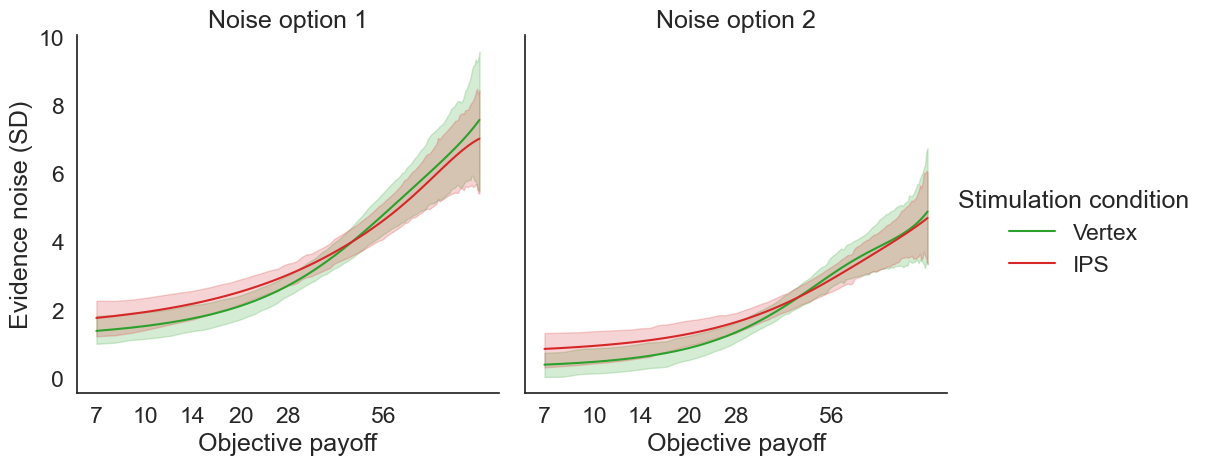

In [606]:
def get_hdi(d, hdi_prob=0.95):
    return az.hdi(d.values, hdi_prob=hdi_prob)
    


# sns.lineplot(x='x', y='perceptual_noise_sd', data=group_curves.reset_index(), errorbar=get_hdi, hue='stimulation_condition', palette=stimulation_palette)
# sns.lineplot(x='x', y='memory_noise_sd', data=group_curves.reset_index(), errorbar=get_hdi, hue='stimulation_condition', palette=stimulation_palette)


# plt.figure()
# sns.lineplot(x='x', y='perceptual_noise_sd', data=curves.reset_index(), errorbar=get_hdi, hue='stimulation_condition', palette=stimulation_palette)
# sns.lineplot(x='x', y='memory_noise_sd', data=curves.reset_index(), errorbar=get_hdi, hue='stimulation_condition', palette=stimulation_palette)

# # Make x-axis log scale
# plt.xscale('log')
# # Put 7/10/24/28 on ticks in natural scale
# plt.xticks([7,10,14,20, 28, 56], [7,10,14,20,28, 56])
# plt.xlabel('Objective payoff')
# plt.ylabel('Perceptual noise')


# sns.despine()

# # Put shaded area between 7 and 14
# plt.axvspan(7, 28, color='gray', alpha=0.2)

tmp = group_curves[['n1_evidence_sd', 'n2_evidence_sd']].stack().to_frame('value')
# tmp.index.set_names('variable', level=2, inplace=True)

# Rename variables to n1 and n2
tmp = tmp.rename(index={'n1_evidence_sd': 'Noise option 1', 'n2_evidence_sd': 'Noise option 2'})

g = sns.relplot(x='x', y='value', hue='stimulation_condition', col='variable', data=tmp.reset_index(), kind='line', errorbar=get_hdi, palette=stimulation_palette)
plt.xscale('log')

# Put 7/10/14/20/28/56 on ticks in natural scale
plt.xticks([7,10,14,20, 28, 56], [7,10,14,20,28, 56])
g.set_axis_labels('Objective payoff', 'Evidence noise (SD)')

g.set_titles('{col_name}')

# Title of legend 'Stimulation condition', Vertex and IPS iso vertex and ips
g._legend.set_title('Stimulation condition')
new_labels = ['Vertex', 'IPS']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# 2D noise

In [539]:
curves['n1_evidence_sd'] = curves['memory_noise_sd'] + curves['perceptual_noise_sd']
curves['n2_evidence_sd'] = curves['perceptual_noise_sd']
curves['all_noise'] = np.sqrt(curves['n1_evidence_sd']**2 + curves['n2_evidence_sd']**2)
mean_curves = curves.groupby(['subject', 'x', 'stimulation_condition']).mean()

In [540]:
import numpy as np
from scipy.interpolate import interp1d


n_safe = np.arange(7, 28.5, .5)

frac = np.linspace(1.0, 4.0, 50)

n_safe = n_safe[:, np.newaxis]
n_risky = n_safe * frac[np.newaxis, :]

frac = np.repeat(frac[np.newaxis, :], n_safe.shape[0], axis=0)


safe_curves = mean_curves.groupby(['subject', 'stimulation_condition']).apply(lambda d: pd.DataFrame(interp1d(d.index.get_level_values('x').values, d, axis=0)(n_safe.ravel()),
                                                                                    index=pd.Index(n_safe.flatten(), name='x'),
                                                                                    columns=d.columns))

n_safe = np.repeat(n_safe, frac.shape[1], axis=1)

risky_curves = mean_curves.groupby(['subject', 'stimulation_condition']).apply(lambda d: pd.DataFrame(interp1d(d.index.get_level_values('x').values, d, axis=0)(n_risky.ravel()),
                                                                                    index=pd.MultiIndex.from_arrays((n_safe.flatten(),
                                                                                                                     frac.flatten()), names=('n_safe', 'frac')),
                                                                                    columns=d.columns))

risky_curves

variable                                       memory_noise_sd  \
subject stimulation_condition n_safe frac                        
1       ips                   7.0    1.000000         0.781952   
                                     1.061224         0.796248   
                                     1.122449         0.810545   
                                     1.183673         0.824782   
                                     1.244898         0.838990   
...                                                        ...   
74      vertex                28.0   3.755102         2.196140   
                                     3.816327         2.146354   
                                     3.877551         2.091768   
                                     3.938776         2.033037   
                                     4.000000         1.970730   

variable                                       perceptual_noise_sd  \
subject stimulation_condition n_safe frac                            
1       ips                   7.0    1.000000             0.746024   
                                     1.061224             0.755109   
                                     1.122449             0.764194   
                                     1.183673             0.773763   
                                     1.244898             0.783573   
...                                                            ...   
74      vertex                28.0   3.755102             2.948841   
                                     3.816327             2.776680   
                                     3.877551             2.607794   
                                     3.938776             2.445322   
                                     4.000000             2.291778   

variable                                       n1_evidence_sd  n2_evidence_sd  \
subject stimulation_condition n_safe frac                                       
1       ips                   7.0    1.000000        1.527976        0.746024   
                                     1.061224        1.551358        0.755109   
                                     1.122449        1.574739        0.764194   
                                     1.183673        1.598545        0.773763   
                                     1.244898        1.622563        0.783573   
...                                                       ...             ...   
74      vertex                28.0   3.755102        5.144981        2.948841   
                                     3.816327        4.923034        2.776680   
                                     3.877551        4.699562        2.607794   
                                     3.938776        4.478359        2.445322   
                                     4.000000        4.262508        2.291778   

variable                                       all_noise  
subject stimulation_condition n_safe frac                 
1       ips                   7.0    1.000000   1.714555  
                                     1.061224   1.739211  
                                     1.122449   1.763867  
                                     1.183673   1.789122  
                                     1.244898   1.814677  
...                                                  ...  
74      vertex                28.0   3.755102   5.953115  
                                     3.816327   5.681741  
                                     3.877551   5.411947  
                                     3.938776   5.148120  
                                     4.000000   4.893783  

[150500 rows x 5 columns]

In [541]:
palette = sns.color_palette()
sns.set(font_scale=1.25, style='white')
sns.set_palette(palette)

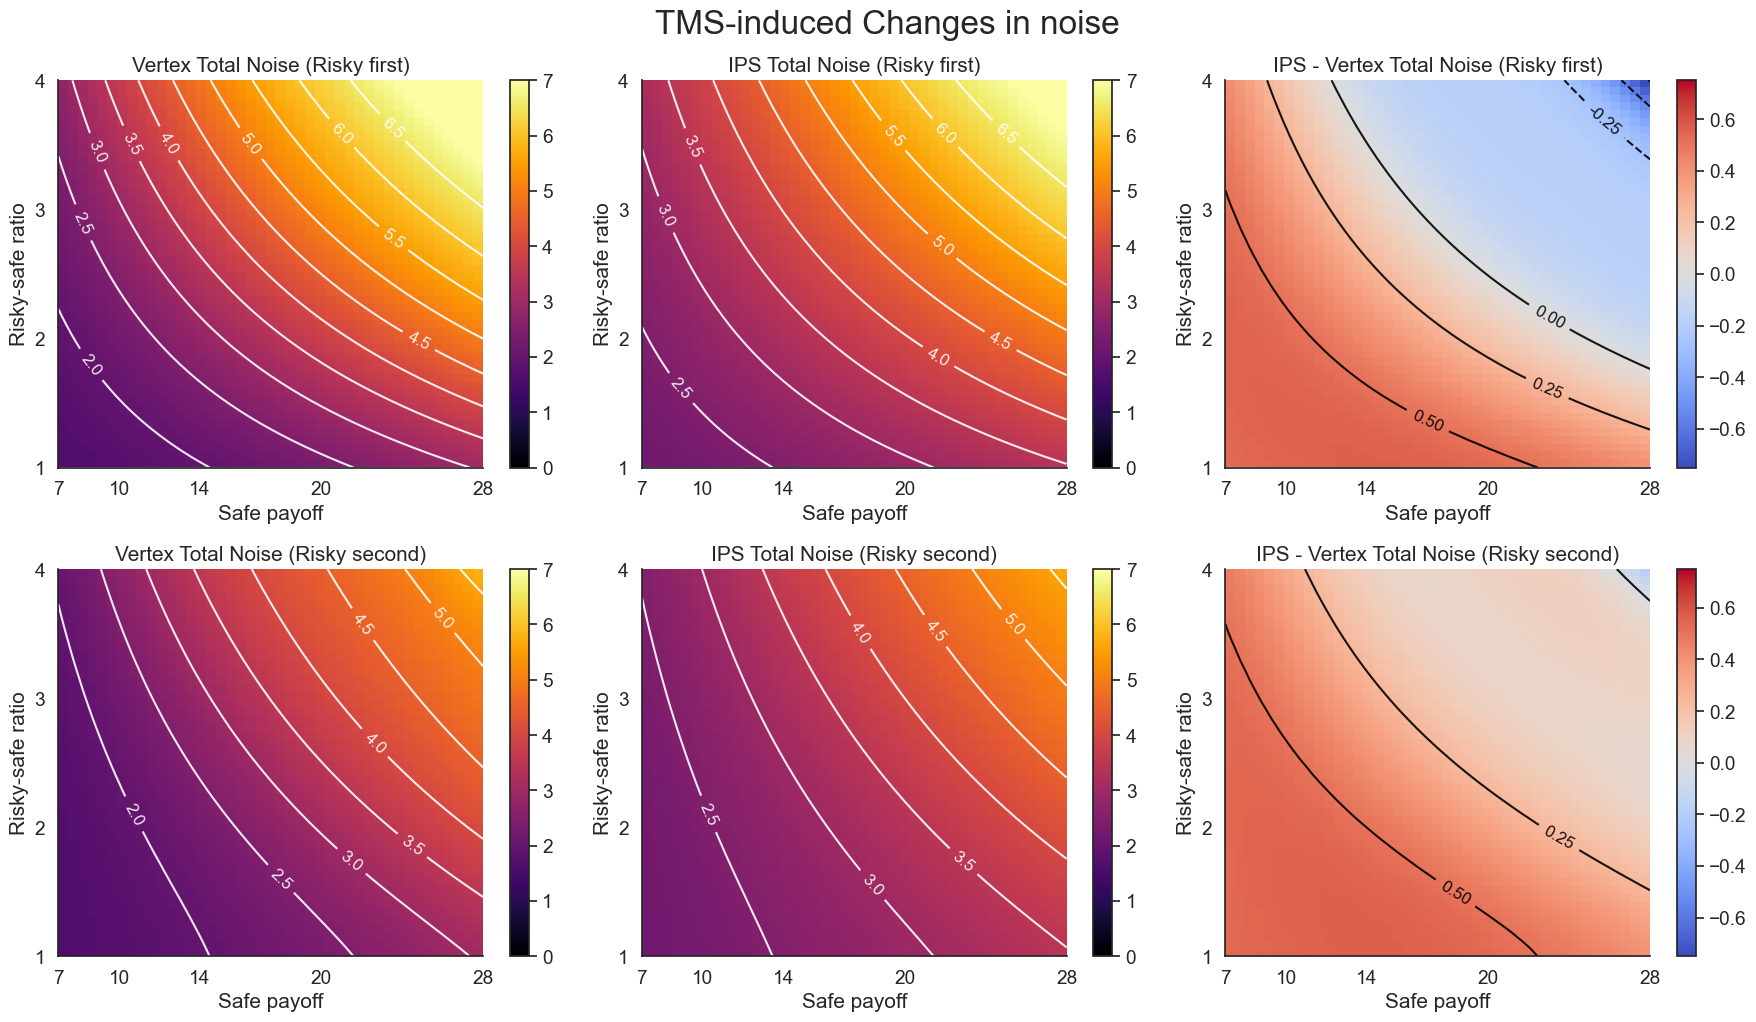

In [542]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cmap = 'inferno'
# Set up the figure and axes
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Define conditions and titles
conditions = ['risky_first', 'safe_first']
titles = {
    'risky_first': {'vertex': 'Vertex Total Noise (Risky first)',
                    'ips': 'IPS Total Noise (Risky first)',
                    'diff': 'IPS - Vertex Total Noise (Risky first)'},
    'safe_first': {'vertex': 'Vertex Total Noise (Risky second)',
                   'ips': 'IPS Total Noise (Risky second)',
                   'diff': 'IPS - Vertex Total Noise (Risky second)'}
}

# Define xticks and yticks
n_safe = np.arange(7, 28.5, 0.5)
frac = np.linspace(1.0, 4.0, 50)
n_safe_ticks = [7, 10, 14, 20, 28]
frac_ticks = [1, 2, 3, 4]
vmin, vmax = 0, 7
levels = np.arange(vmin, vmax, .5)  # Fewer levels for clearer labels
diff_levels = np.linspace(-0.75, 0.75, 7)  # Levels for the difference plot

noise_diff = {}

# Loop over conditions
for i, condition in enumerate(conditions):
    if condition == 'risky_first':
        safe_noise = safe_curves.groupby(['stimulation_condition', 'x']).mean()['n2_evidence_sd']
        risky_noise = risky_curves.groupby(['stimulation_condition', 'n_safe', 'frac']).mean()['n1_evidence_sd']
    else:
        safe_noise = safe_curves.groupby(['stimulation_condition', 'x']).mean()['n1_evidence_sd']
        risky_noise = risky_curves.groupby(['stimulation_condition', 'n_safe', 'frac']).mean()['n2_evidence_sd']

    # Calculate noise for Vertex and IPS
    noise_vertex = np.sqrt(safe_noise.loc['vertex'].values[np.newaxis, :]**2 + risky_noise.loc['vertex'].unstack('n_safe').values**2)
    noise_ips = np.sqrt(safe_noise.loc['ips'].values[np.newaxis, :]**2 + risky_noise.loc['ips'].unstack('n_safe').values**2)
    noise_diff[condition]  = noise_ips - noise_vertex

    # Define extent for imshow: [xmin, xmax, ymin, ymax]
    xmin, xmax = n_safe.min(), n_safe.max()
    ymin, ymax = frac.min(), frac.max()

    # Plot Vertex (left column)
    im1 = axes[i, 0].imshow(noise_vertex, aspect='auto', origin='lower',
                           extent=[xmin, xmax, ymin, ymax], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(titles[condition]['vertex'])

    # Add labeled contours
    contours1 = axes[i, 0].contour(noise_vertex, levels=levels, extent=[xmin, xmax, ymin, ymax],
                                   colors='white', linewidths=1.5, alpha=0.9)
    axes[i, 0].clabel(contours1, levels=levels, fmt='%1.1f', fontsize=12, colors='white')

    # Plot IPS (middle column)
    im2 = axes[i, 1].imshow(noise_ips, aspect='auto', origin='lower',
                           extent=[xmin, xmax, ymin, ymax], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 1].set_title(titles[condition]['ips'])

    # Add labeled contours
    contours2 = axes[i, 1].contour(noise_ips, levels=levels, extent=[xmin, xmax, ymin, ymax],
                                   colors='white', linewidths=1.5, alpha=0.9)
    axes[i, 1].clabel(contours2, levels=levels, fmt='%1.1f', fontsize=12, colors='white')

    # Plot Difference (right column)
    im3 = axes[i, 2].imshow(noise_diff[condition], aspect='auto', origin='lower',
                           extent=[xmin, xmax, ymin, ymax], cmap='coolwarm', vmin=-0.75, vmax=0.75)
    axes[i, 2].set_title(titles[condition]['diff'])
    # Add labeled contours (black for visibility)
    contours3 = axes[i, 2].contour(noise_diff[condition], levels=diff_levels, extent=[xmin, xmax, ymin, ymax],
                                   colors='black', linewidths=1.5, alpha=0.9)
    axes[i, 2].clabel(contours3, levels=diff_levels, fmt='%1.2f', fontsize=12, colors='black')

    # Add colorbars
    fig.colorbar(im1, ax=axes[i, 0])
    fig.colorbar(im2, ax=axes[i, 1])
    fig.colorbar(im3, ax=axes[i, 2])

for ax in axes.flatten():
    sns.despine(ax=ax)
    ax.set_xticks(n_safe_ticks)
    ax.set_yticks(frac_ticks)
    ax.set_xlabel('Safe payoff')
    ax.set_ylabel('Risky-safe ratio')

plt.tight_layout()

fig.suptitle('TMS-induced Changes in noise', fontsize=24, y=1.025)

plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/noise_heatmaps.pdf',bbox_inches='tight')
plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/noise_heatmaps.png', dpi=300,  bbox_inches='tight')


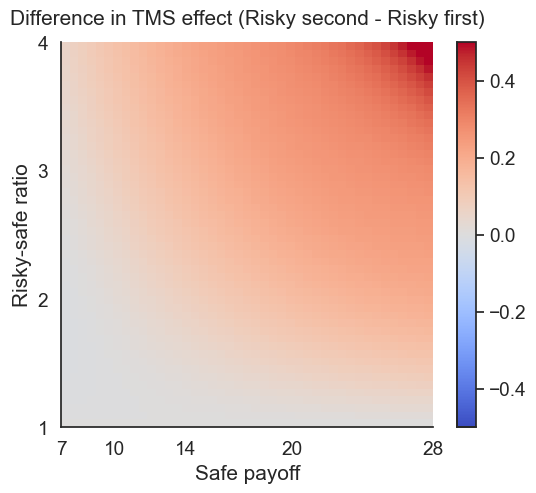

In [543]:
# Make exactly the same size as the subplots above
fig = plt.figure(figsize=(6,5))
plt.imshow(noise_diff['safe_first'] - noise_diff['risky_first'], aspect='auto', origin='lower',
           extent=[xmin, xmax, ymin, ymax], cmap='coolwarm', vmin=-0.5, vmax=0.5)
plt.title('Difference in TMS effect (Risky second - Risky first)', y=1.025)
plt.xlabel('n_safe')
plt.ylabel('Risky-safe ratio')
plt.xlabel('Safe payoff')
plt.xticks(n_safe_ticks)
plt.yticks(frac_ticks)
plt.colorbar()
sns.despine()

plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/noise_heatmap_difference.pdf')
plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/noise_heatmap_difference.png', dpi=300)

# Average distortions

In [544]:
from bauer.utils.bayes import get_posterior

In [545]:
safe_curves['prior_mu'] = mean_priors.unstack('parameter').droplevel(0, axis=1)['safe_prior_mu']
safe_curves['prior_sd'] = mean_priors.unstack('parameter').droplevel(0, axis=1)['safe_prior_sd']

risky_curves['prior_mu'] = mean_priors.unstack('parameter').droplevel(0, axis=1)['risky_prior_mu']
risky_curves['prior_sd'] = mean_priors.unstack('parameter').droplevel(0, axis=1)['risky_prior_sd']

In [546]:
safe_estimates_safe_first, _ = get_posterior(safe_curves.index.get_level_values('x').values, safe_curves['n1_evidence_sd'],
                                         safe_curves['prior_mu'], safe_curves['prior_sd'])

safe_estimates_risky_first, _ = get_posterior(safe_curves.index.get_level_values('x').values, safe_curves['n2_evidence_sd'],
                                           safe_curves['prior_mu'], safe_curves['prior_sd'])

risky_estimates_safe_first, _ = get_posterior(risky_curves.index.get_level_values('n_safe').values * risky_curves.index.get_level_values('frac').values, risky_curves['n2_evidence_sd'],
                                           risky_curves['prior_mu'], risky_curves['prior_sd'])

risky_estimates_risky_first, _ = get_posterior(risky_curves.index.get_level_values('n_safe').values * risky_curves.index.get_level_values('frac').values, risky_curves['n1_evidence_sd'],
                                           risky_curves['prior_mu'], risky_curves['prior_sd'])


safe_estimates_safe_first = safe_estimates_safe_first.groupby(['stimulation_condition', 'x']).mean()
safe_estimates_risky_first = safe_estimates_risky_first.groupby(['stimulation_condition', 'x']).mean()
risky_estimates_risky_first = risky_estimates_risky_first.groupby(['stimulation_condition', 'n_safe', 'frac']).mean()
risky_estimates_safe_first = risky_estimates_safe_first.groupby(['stimulation_condition', 'n_safe', 'frac']).mean()

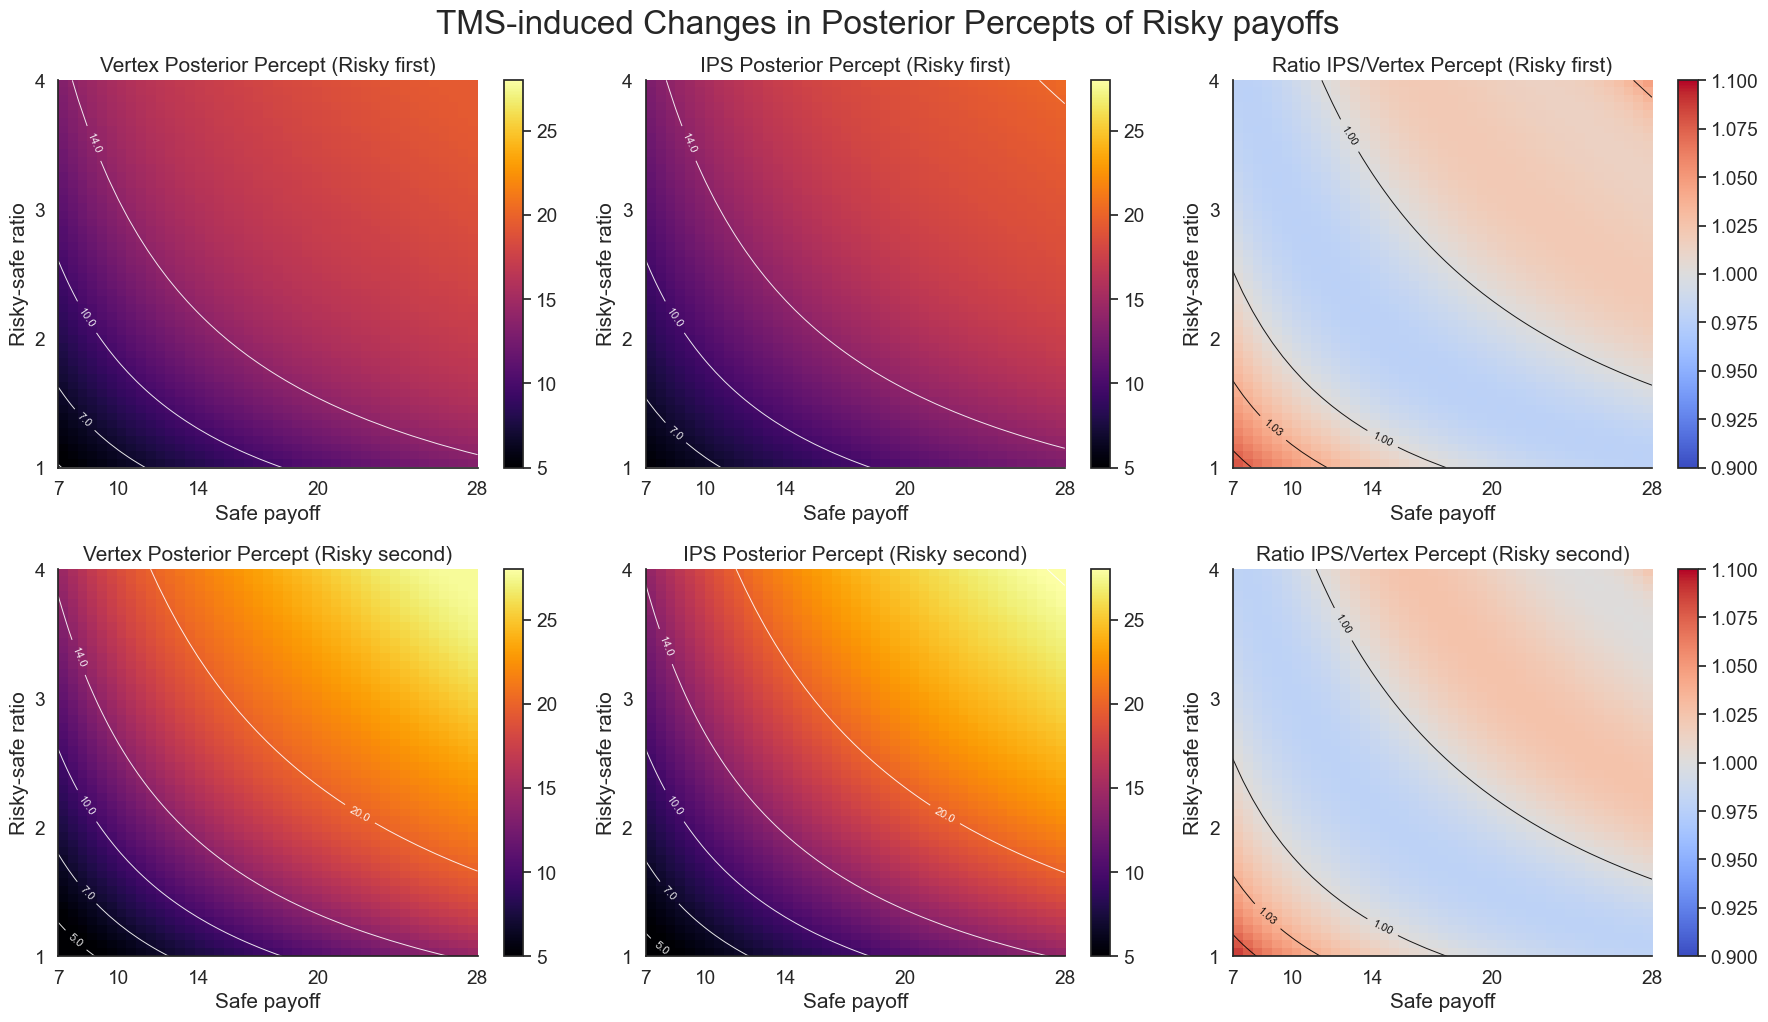

In [547]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cmap = 'inferno'  # or 'viridis', 'plasma', etc.
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Define conditions and titles
conditions = ['risky_first', 'safe_first']
titles = {
    'risky_first': {'vertex': 'Vertex Posterior Percept (Risky first)',
                    'ips': 'IPS Posterior Percept (Risky first)',
                    'diff': 'Ratio IPS/Vertex Percept (Risky first)'},
    'safe_first': {'vertex': 'Vertex Posterior Percept (Risky second)',
                   'ips': 'IPS Posterior Percept (Risky second)',
                   'diff': 'Ratio IPS/Vertex Percept (Risky second)'}
}

# Define xticks and yticks
n_safe = np.arange(7, 28.5, 0.5)
frac = np.linspace(1.0, 4.0, 50)
n_safe_ticks = [7, 10, 14, 20, 28]
frac_ticks = [1, 2, 3, 4]

# Define contour levels
vmin, vmax = 5, 28
levels = [5, 7, 10, 14, 20, 28]

vmin_diff, vmax_diff = .9, 1.1
diff_levels = np.linspace(vmin_diff, vmax_diff, 7)  # For difference plots

estimate_diff = {}

# Loop over conditions
for i, condition in enumerate(conditions):
    # Get the estimates for the current condition
    if condition == 'risky_first':
        safe_estimate = safe_estimates_risky_first  # Use the correct variable name
        risky_estimate = risky_estimates_risky_first  # Use the correct variable name
    else:
        safe_estimate = safe_estimates_safe_first  # Use the correct variable name
        risky_estimate = risky_estimates_safe_first  # Use the correct variable name

    # Reshape the estimates to match the grid (n_safe x frac)
    # Assuming safe_estimate is indexed by 'x' and risky_estimate by 'n_safe' and 'frac'
    safe_estimate_vertex = safe_estimate.loc['vertex'].values
    safe_estimate_ips = safe_estimate.loc['ips'].values

    # Reshape risky_estimate (assuming it's a MultiIndex DataFrame with 'n_safe' and 'frac')
    risky_estimate_vertex = risky_estimate.loc['vertex'].unstack('n_safe').values
    risky_estimate_ips = risky_estimate.loc['ips'].unstack('n_safe').values

    # Combine the estimates (e.g., sum or another operation)
    # Here, we'll just plot the safe and risky estimates separately
    # If you want to combine them, define the operation (e.g., sum, mean, etc.)
    # estimate_vertex = safe_estimate_vertex[:, np.newaxis] + risky_estimate_vertex  # Example: sum
    estimate_vertex = (risky_estimate_vertex * .55)
    estimate_ips = (risky_estimate_ips * .55)


    # estimate_ips = safe_estimate_ips[:, np.newaxis] + risky_estimate_ips  # Example: sum
    estimate_diff[condition] = estimate_ips / estimate_vertex

    # Define extent for imshow: [xmin, xmax, ymin, ymax]
    xmin, xmax = n_safe.min(), n_safe.max()
    ymin, ymax = frac.min(), frac.max()

    # Plot Vertex (left column)
    im1 = axes[i, 0].imshow(estimate_vertex, aspect='auto', origin='lower',
                           extent=[xmin, xmax, ymin, ymax], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(titles[condition]['vertex'])
    axes[i, 0].set_xlabel('n_safe')
    axes[i, 0].set_ylabel('Risky-safe ratio')
    axes[i, 0].set_xticks(n_safe_ticks)
    axes[i, 0].set_yticks(frac_ticks)
    # Add labeled contours
    contours1 = axes[i, 0].contour(estimate_vertex, levels=levels, extent=[xmin, xmax, ymin, ymax],
                                   colors='white', linewidths=0.7, alpha=0.9)
    axes[i, 0].clabel(contours1, levels=levels, fmt='%1.1f', fontsize=8, colors='white')

    # Plot IPS (middle column)
    im2 = axes[i, 1].imshow(estimate_ips, aspect='auto', origin='lower',
                           extent=[xmin, xmax, ymin, ymax], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 1].set_title(titles[condition]['ips'])
    axes[i, 1].set_xlabel('n_safe')
    axes[i, 1].set_ylabel('Risky-safe ratio')
    axes[i, 1].set_xticks(n_safe_ticks)
    axes[i, 1].set_yticks(frac_ticks)
    # Add labeled contours
    contours2 = axes[i, 1].contour(estimate_ips, levels=levels, extent=[xmin, xmax, ymin, ymax],
                                   colors='white', linewidths=0.7, alpha=0.9)
    axes[i, 1].clabel(contours2, levels=levels, fmt='%1.1f', fontsize=8, colors='white')

    # Plot Difference (right column)
    im3 = axes[i, 2].imshow(estimate_diff[condition], aspect='auto', origin='lower',
                           extent=[xmin, xmax, ymin, ymax], cmap='coolwarm', vmin=vmin_diff, vmax=vmax_diff)
    axes[i, 2].set_title(titles[condition]['diff'])
    axes[i, 2].set_xlabel('n_safe')
    axes[i, 2].set_ylabel('Risky-safe ratio')
    axes[i, 2].set_xticks(n_safe_ticks)
    axes[i, 2].set_yticks(frac_ticks)
    # Add labeled contours (black for visibility)
    contours3 = axes[i, 2].contour(estimate_diff[condition], levels=diff_levels, extent=[xmin, xmax, ymin, ymax],
                                   colors='black', linewidths=0.7, alpha=0.9)
    axes[i, 2].clabel(contours3, levels=diff_levels, fmt='%1.2f', fontsize=8, colors='black')

    # Add colorbars
    fig.colorbar(im1, ax=axes[i, 0])
    fig.colorbar(im2, ax=axes[i, 1])
    fig.colorbar(im3, ax=axes[i, 2])

plt.tight_layout()

plt.suptitle('TMS-induced Changes in Posterior Percepts of Risky payoffs', fontsize=24, y=1.025)

for ax in axes.flatten():
    sns.despine(ax=ax)
    ax.set_xticks(n_safe_ticks)
    ax.set_yticks(frac_ticks)
    ax.set_xlabel('Safe payoff')
    ax.set_ylabel('Risky-safe ratio')

plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/risky_percept.pdf', bbox_inches='tight')
plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/risky_percepts.png', dpi=300, bbox_inches='tight')

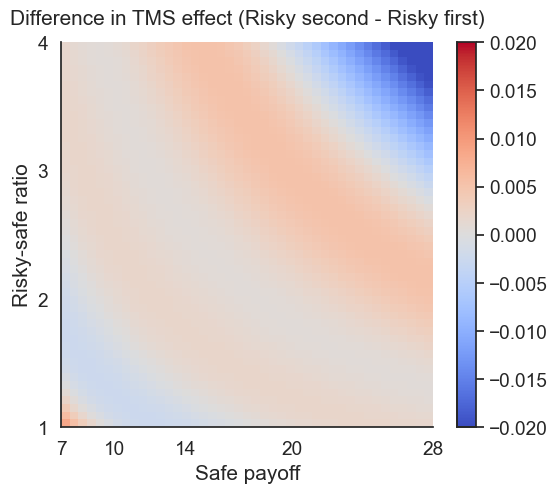

In [548]:
# Make exactly the same size as the subplots above
fig = plt.figure(figsize=(6,5))
plt.imshow(estimate_diff['safe_first'] - estimate_diff['risky_first'], aspect='auto', origin='lower',
           extent=[xmin, xmax, ymin, ymax], cmap='coolwarm', vmin=-0.02, vmax=0.02)
plt.title('Difference in TMS effect (Risky second - Risky first)', y=1.025)
plt.xlabel('n_safe')
plt.ylabel('Risky-safe ratio')
plt.xlabel('Safe payoff')
plt.xticks(n_safe_ticks)
plt.yticks(frac_ticks)
plt.colorbar()
sns.despine()

plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/risky_percept_order_tms_difference.pdf')
plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/risky_percept_order_tms_difference.png', dpi=300)

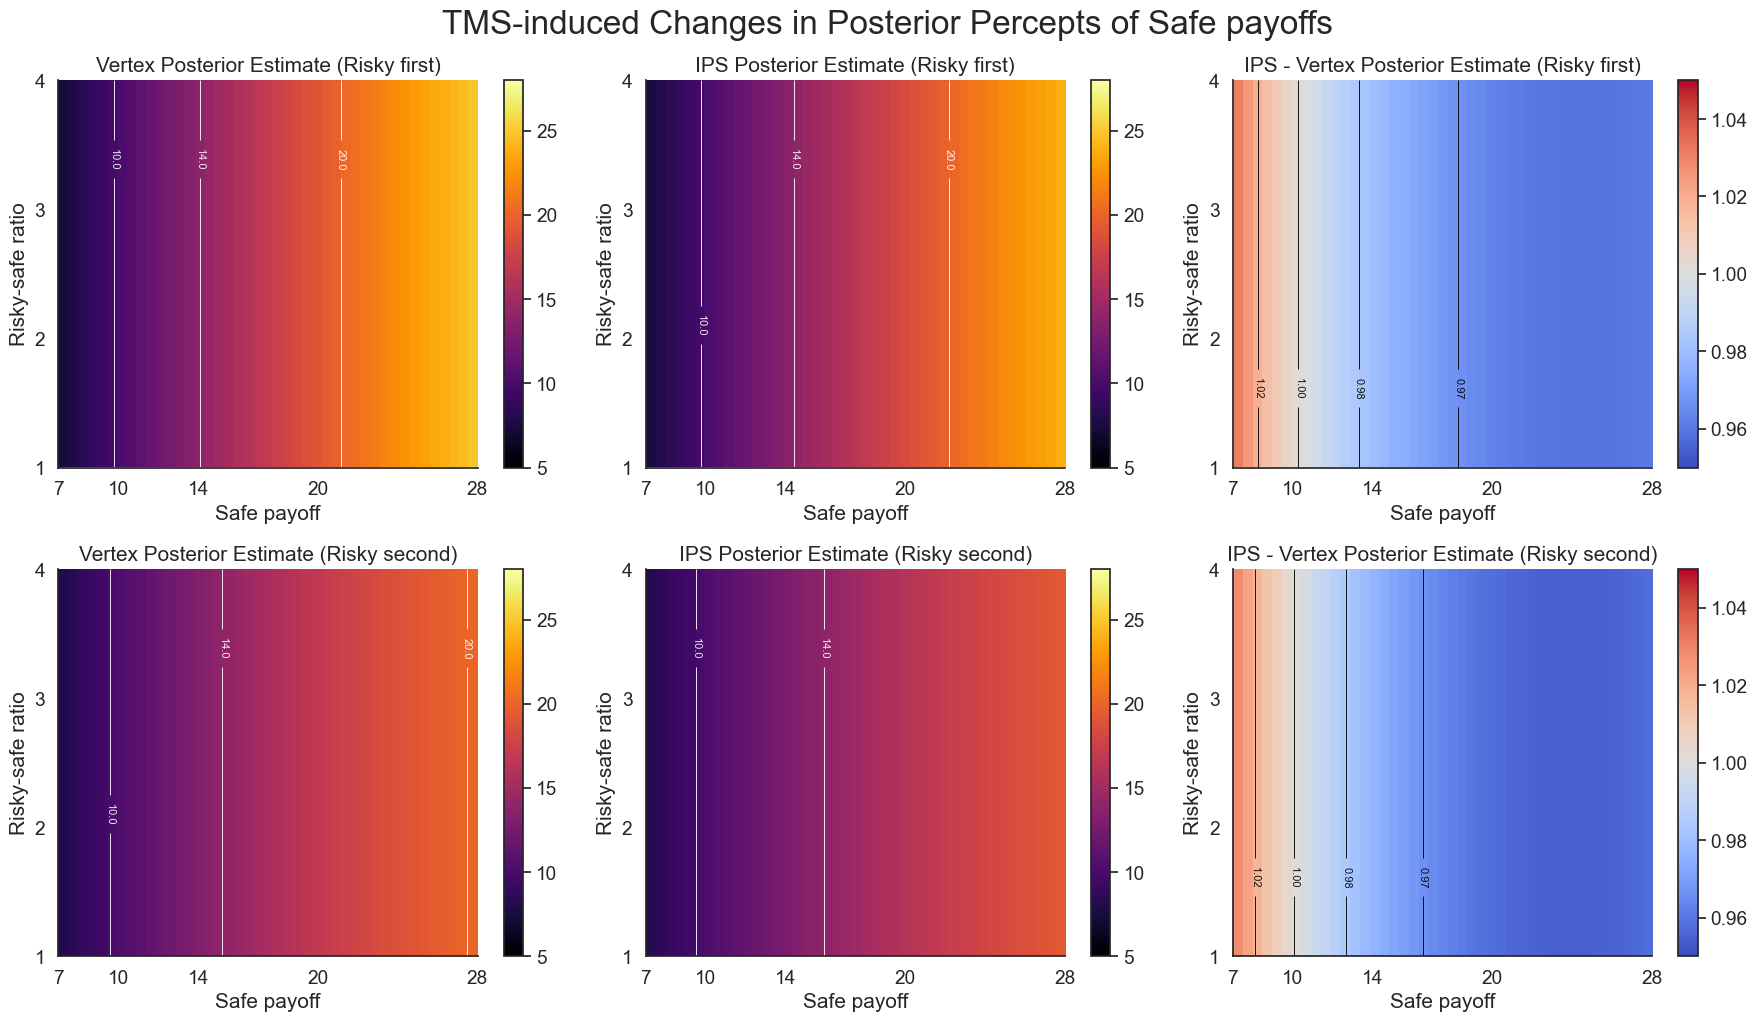

In [549]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cmap = 'inferno'  # or 'viridis', 'plasma', etc.
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Define conditions and titles
conditions = ['risky_first', 'safe_first']
titles = {
    'risky_first': {'vertex': 'Vertex Posterior Estimate (Risky first)',
                    'ips': 'IPS Posterior Estimate (Risky first)',
                    'diff': 'IPS - Vertex Posterior Estimate (Risky first)'},
    'safe_first': {'vertex': 'Vertex Posterior Estimate (Risky second)',
                   'ips': 'IPS Posterior Estimate (Risky second)',
                   'diff': 'IPS - Vertex Posterior Estimate (Risky second)'}
}

# Define xticks and yticks
n_safe = np.arange(7, 28.5, 0.5)
frac = np.linspace(1.0, 4.0, 50)
n_safe_ticks = [7, 10, 14, 20, 28]
frac_ticks = [1, 2, 3, 4]

# Define contour levels
vmin, vmax = 5, 28
levels = [5, 7, 10, 14, 20, 28]

vmin_diff, vmax_diff = .95, 1.05
diff_levels = np.linspace(vmin_diff, vmax_diff, 7)  # For difference plots

estimate_diff = {}

# Loop over conditions
for i, condition in enumerate(conditions):
    # Get the estimates for the current condition
    if condition == 'risky_first':
        safe_estimate = safe_estimates_risky_first  # Use the correct variable name
        risky_estimate = risky_estimates_risky_first  # Use the correct variable name
    else:
        safe_estimate = safe_estimates_safe_first  # Use the correct variable name
        risky_estimate = risky_estimates_safe_first  # Use the correct variable name

    # Reshape the estimates to match the grid (n_safe x frac)
    # Assuming safe_estimate is indexed by 'x' and risky_estimate by 'n_safe' and 'frac'
    safe_estimate_vertex = safe_estimate.loc['vertex'].values
    safe_estimate_ips = safe_estimate.loc['ips'].values

    # Reshape risky_estimate (assuming it's a MultiIndex DataFrame with 'n_safe' and 'frac')
    risky_estimate_vertex = risky_estimate.loc['vertex'].unstack('n_safe').values
    risky_estimate_ips = risky_estimate.loc['ips'].unstack('n_safe').values

    # Combine the estimates (e.g., sum or another operation)
    # Here, we'll just plot the safe and risky estimates separately
    # If you want to combine them, define the operation (e.g., sum, mean, etc.)
    # estimate_vertex = safe_estimate_vertex[:, np.newaxis] + risky_estimate_vertex  # Example: sum
    estimate_vertex = np.repeat(safe_estimate_vertex[np.newaxis, :], len(frac), axis=0)
    estimate_ips = np.repeat(safe_estimate_ips[np.newaxis, :], len(frac), axis=0)


    # estimate_ips = safe_estimate_ips[:, np.newaxis] + risky_estimate_ips  # Example: sum
    estimate_diff[condition] = estimate_ips / estimate_vertex

    # Define extent for imshow: [xmin, xmax, ymin, ymax]
    xmin, xmax = n_safe.min(), n_safe.max()
    ymin, ymax = frac.min(), frac.max()

    # Plot Vertex (left column)
    im1 = axes[i, 0].imshow(estimate_vertex, aspect='auto', origin='lower',
                           extent=[xmin, xmax, ymin, ymax], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(titles[condition]['vertex'])
    axes[i, 0].set_xlabel('n_safe')
    axes[i, 0].set_ylabel('Risky-safe ratio')
    axes[i, 0].set_xticks(n_safe_ticks)
    axes[i, 0].set_yticks(frac_ticks)
    # Add labeled contours
    contours1 = axes[i, 0].contour(estimate_vertex, levels=levels, extent=[xmin, xmax, ymin, ymax],
                                   colors='white', linewidths=0.7, alpha=0.9)
    axes[i, 0].clabel(contours1, levels=levels, fmt='%1.1f', fontsize=8, colors='white')

    # Plot IPS (middle column)
    im2 = axes[i, 1].imshow(estimate_ips, aspect='auto', origin='lower',
                           extent=[xmin, xmax, ymin, ymax], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 1].set_title(titles[condition]['ips'])
    axes[i, 1].set_xlabel('n_safe')
    axes[i, 1].set_ylabel('Risky-safe ratio')
    axes[i, 1].set_xticks(n_safe_ticks)
    axes[i, 1].set_yticks(frac_ticks)
    # Add labeled contours
    contours2 = axes[i, 1].contour(estimate_ips, levels=levels, extent=[xmin, xmax, ymin, ymax],
                                   colors='white', linewidths=0.7, alpha=0.9)
    axes[i, 1].clabel(contours2, levels=levels, fmt='%1.1f', fontsize=8, colors='white')

    # Plot Difference (right column)
    im3 = axes[i, 2].imshow(estimate_diff[condition], aspect='auto', origin='lower',
                           extent=[xmin, xmax, ymin, ymax], cmap='coolwarm', vmin=vmin_diff, vmax=vmax_diff,)
    axes[i, 2].set_title(titles[condition]['diff'])
    axes[i, 2].set_xlabel('n_safe')
    axes[i, 2].set_ylabel('Risky-safe ratio')
    axes[i, 2].set_xticks(n_safe_ticks)
    axes[i, 2].set_yticks(frac_ticks)
    # Add labeled contours (black for visibility)
    contours3 = axes[i, 2].contour(estimate_diff[condition], levels=diff_levels, extent=[xmin, xmax, ymin, ymax],
                                   colors='black', linewidths=0.7, alpha=0.9)
    axes[i, 2].clabel(contours3, levels=diff_levels, fmt='%1.2f', fontsize=8, colors='black')

    # Add colorbars
    fig.colorbar(im1, ax=axes[i, 0])
    fig.colorbar(im2, ax=axes[i, 1])
    fig.colorbar(im3, ax=axes[i, 2])

plt.tight_layout()

fig.suptitle('TMS-induced Changes in Posterior Percepts of Safe payoffs', fontsize=24, y=1.025)

for ax in axes.flatten():
    sns.despine(ax=ax)
    ax.set_xticks(n_safe_ticks)
    ax.set_yticks(frac_ticks)
    ax.set_xlabel('Safe payoff')
    ax.set_ylabel('Risky-safe ratio')

plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/safe_percept.pdf', bbox_inches='tight')
plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/safe_percepts.png', bbox_inches='tight', dpi=300)

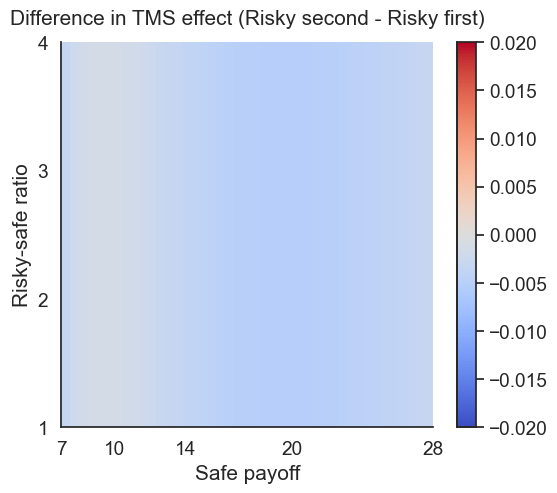

In [550]:
# Make exactly the same size as the subplots above
fig = plt.figure(figsize=(6,5))
plt.imshow(estimate_diff['safe_first'] - estimate_diff['risky_first'], aspect='auto', origin='lower',
           extent=[xmin, xmax, ymin, ymax], cmap='coolwarm', vmin=-0.02, vmax=0.02)
plt.title('Difference in TMS effect (Risky second - Risky first)', y=1.025)
plt.xlabel('n_safe')
plt.ylabel('Risky-safe ratio')
plt.xlabel('Safe payoff')
plt.xticks(n_safe_ticks)
plt.yticks(frac_ticks)
plt.colorbar()
sns.despine()

plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/safe_percept_order_tms_difference.pdf', bbox_inches='tight')
plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/safe_percept_order_tms_difference.png', bbox_inches='tight', dpi=300)

In [ ]:

levels

array([0.75, 0.8 , 0.85, 0.9 , 0.95, 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 ,
       1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85,
       1.9 ])

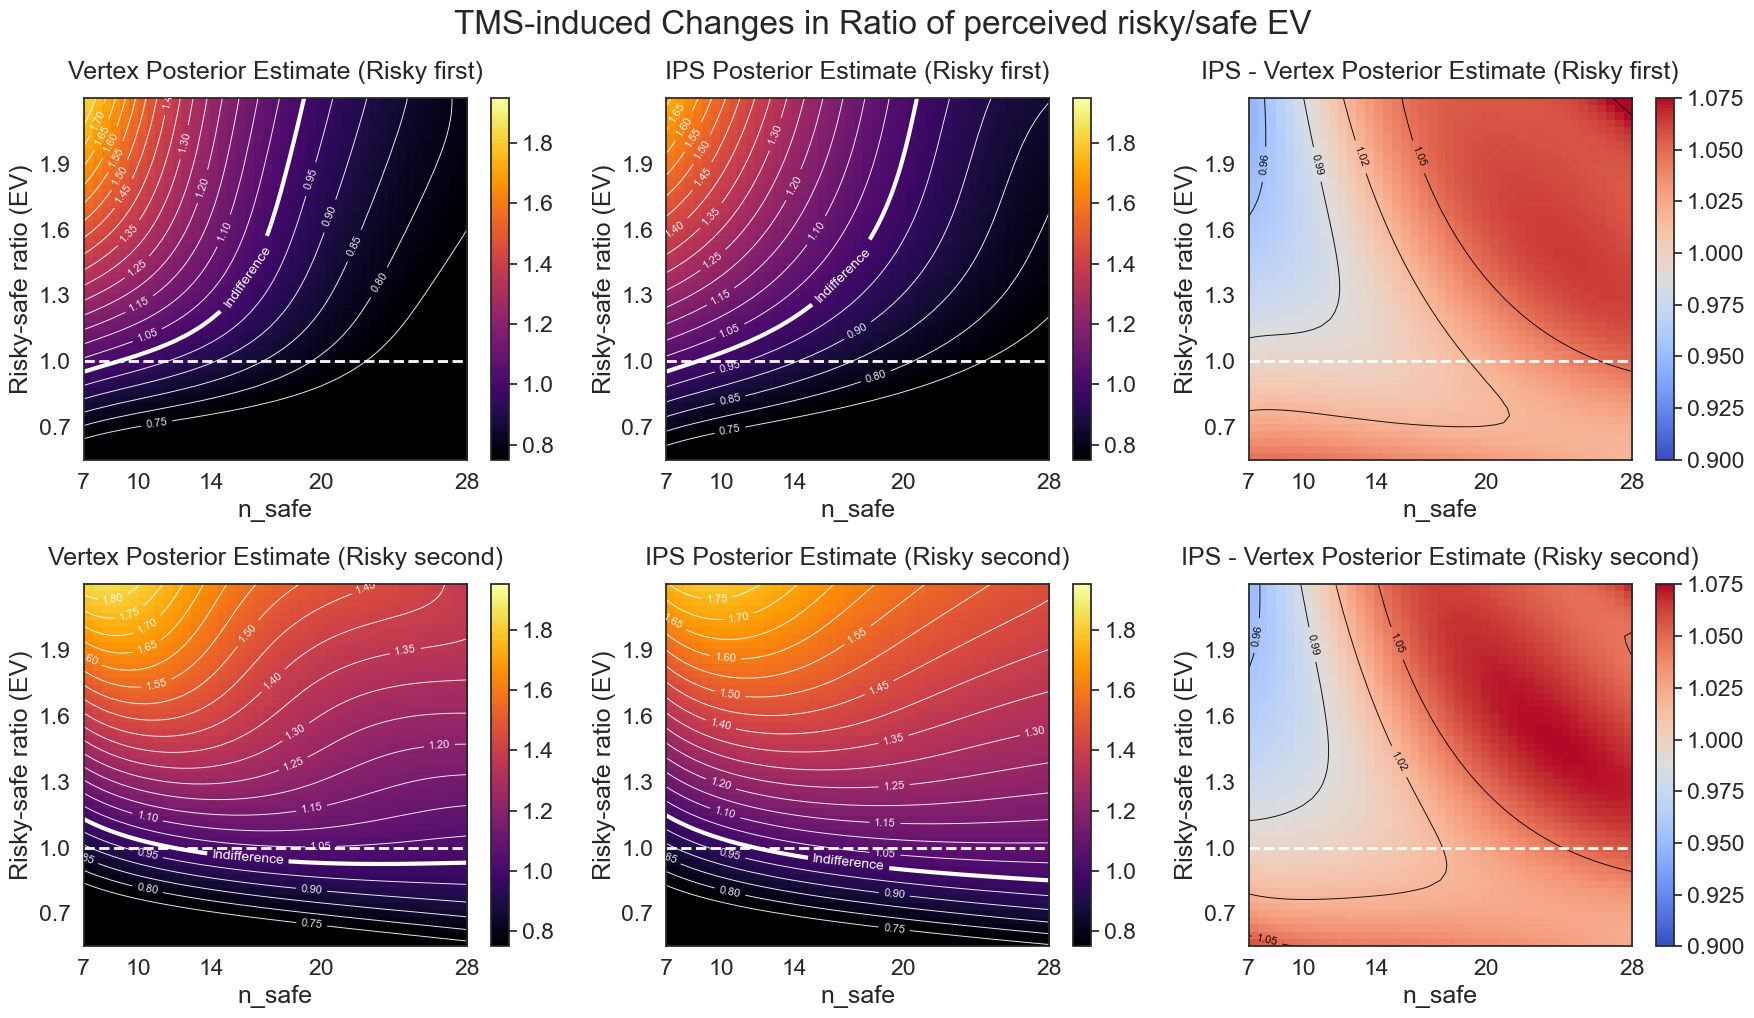

In [706]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cmap = 'inferno'  # or 'viridis', 'plasma', etc.
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Define conditions and titles
conditions = ['risky_first', 'safe_first']
titles = {
    'risky_first': {'vertex': 'Vertex Posterior Estimate (Risky first)',
                    'ips': 'IPS Posterior Estimate (Risky first)',
                    'diff': 'IPS - Vertex Posterior Estimate (Risky first)'},
    'safe_first': {'vertex': 'Vertex Posterior Estimate (Risky second)',
                   'ips': 'IPS Posterior Estimate (Risky second)',
                   'diff': 'IPS - Vertex Posterior Estimate (Risky second)'}
}

# Define xticks and yticks
n_safe = np.arange(7, 28.5, 0.5)
frac = np.linspace(1.0, 4.0, 50) * .55
n_safe_ticks = [7, 10, 14, 20, 28]
frac_ticks = [.7, 1.0, 1.3, 1.6, 1.9]

# Define contour levels
vmin, vmax = 0.75, 1.95
levels = np.linspace(vmin, vmax, 25)  # 25 levels between vmin and vmax
levels = levels[~np.isclose(levels, 1.0, atol=1e-6)]  # Exclude values close to 1.0

diff_vmin, diff_vmax = .9, 1.075  # Adjust based on your difference ranges
diff_levels = np.linspace(diff_vmin, diff_vmax, 7)  # For difference plots

estimate_diff = {}

# Loop over conditions
for i, condition in enumerate(conditions):
    # Get the estimates for the current condition
    if condition == 'risky_first':
        safe_estimate = safe_estimates_risky_first  # Use the correct variable name
        risky_estimate = risky_estimates_risky_first  # Use the correct variable name
    else:
        safe_estimate = safe_estimates_safe_first  # Use the correct variable name
        risky_estimate = risky_estimates_safe_first  # Use the correct variable name

    # Reshape the estimates to match the grid (n_safe x frac)
    # Assuming safe_estimate is indexed by 'x' and risky_estimate by 'n_safe' and 'frac'
    safe_estimate_vertex = safe_estimate.loc['vertex'].values
    safe_estimate_ips = safe_estimate.loc['ips'].values

    # Reshape risky_estimate (assuming it's a MultiIndex DataFrame with 'n_safe' and 'frac')
    risky_estimate_vertex = risky_estimate.loc['vertex'].unstack('n_safe').values
    risky_estimate_ips = risky_estimate.loc['ips'].unstack('n_safe').values

    # Combine the estimates (e.g., sum or another operation)
    # Here, we'll just plot the safe and risky estimates separately
    # If you want to combine them, define the operation (e.g., sum, mean, etc.)
    # estimate_vertex = safe_estimate_vertex[:, np.newaxis] + risky_estimate_vertex  # Example: sum
    estimate_vertex = (risky_estimate_vertex * .55) / safe_estimate_vertex[np.newaxis, :]  # Example: ratio
    estimate_ips = (risky_estimate_ips * .55) / safe_estimate_ips[np.newaxis, :]  # Example: ratio


    # estimate_ips = safe_estimate_ips[:, np.newaxis] + risky_estimate_ips  # Example: sum
    estimate_diff[condition] = estimate_ips / estimate_vertex

    # Define extent for imshow: [xmin, xmax, ymin, ymax]
    xmin, xmax = n_safe.min(), n_safe.max()
    ymin, ymax = frac.min(), frac.max()

    # Plot Vertex (left column)
    im1 = axes[i, 0].imshow(estimate_vertex, aspect='auto', origin='lower',
                           extent=[xmin, xmax, ymin, ymax], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(titles[condition]['vertex'], y=1.03)
    axes[i, 0].set_xlabel('n_safe')
    axes[i, 0].set_ylabel('Risky-safe ratio (EV)')
    axes[i, 0].set_xticks(n_safe_ticks)
    axes[i, 0].set_yticks(frac_ticks)
    # Add labeled contours
    contours1 = axes[i, 0].contour(estimate_vertex, levels=levels, extent=[xmin, xmax, ymin, ymax],
                                   colors='white', linewidths=0.7, alpha=0.9)
    axes[i, 0].clabel(contours1, levels=levels, fmt='%1.2f', fontsize=8, colors='white')

    axes[i, 0].axhline(y=1., c='white', ls='--', lw=2)

    # Extra thick contour at 1.0
    contour1 = axes[i, 0].contour(estimate_vertex, levels=[1.0], extent=[xmin, xmax, ymin, ymax],
                   colors='white', linewidths=3.0, linestyles='-', alpha=1.0)
    # Put 'indifference label
    axes[i, 0].clabel(contour1, levels=[1.0], fmt={1.0: 'Indifference'}, fontsize=10, colors='white')

    # Plot IPS (middle column)
    im2 = axes[i, 1].imshow(estimate_ips, aspect='auto', origin='lower',
                           extent=[xmin, xmax, ymin, ymax], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 1].set_title(titles[condition]['ips'], y=1.03)
    axes[i, 1].set_xlabel('n_safe')
    axes[i, 1].set_ylabel('Risky-safe ratio (EV)')
    axes[i, 1].set_xticks(n_safe_ticks)
    axes[i, 1].set_yticks(frac_ticks)
    # Add labeled contours
    contours2 = axes[i, 1].contour(estimate_ips, levels=levels, extent=[xmin, xmax, ymin, ymax],
                                   colors='white', linewidths=0.7, alpha=0.9)
    axes[i, 1].clabel(contours2, levels=levels, fmt='%1.2f', fontsize=8, colors='white')

    # Extra thick contour at 1.0
    contour2 = axes[i, 1].contour(estimate_ips, levels=[1.0], extent=[xmin, xmax, ymin, ymax],
                   colors='white', linewidths=3.0, linestyles='-', alpha=1.0)
    # Put 'indifference label
    axes[i, 1].clabel(contour2, levels=[1.0], fmt={1.0: 'Indifference'}, fontsize=10, colors='white')

    axes[i, 1].axhline(y=1., c='white', ls='--', lw=2)

    # Plot Difference (right column)
    im3 = axes[i, 2].imshow(estimate_diff[condition], aspect='auto', origin='lower',
                           extent=[xmin, xmax, ymin, ymax], cmap='coolwarm', vmin=diff_vmin, vmax=diff_vmax)
    axes[i, 2].set_title(titles[condition]['diff'], y=1.03)
    axes[i, 2].set_xlabel('n_safe')
    axes[i, 2].set_ylabel('Risky-safe ratio (EV)')
    axes[i, 2].set_xticks(n_safe_ticks)
    axes[i, 2].set_yticks(frac_ticks)
    # Add labeled contours (black for visibility)
    contours3 = axes[i, 2].contour(estimate_diff[condition], levels=diff_levels, extent=[xmin, xmax, ymin, ymax],
                                   colors='black', linewidths=0.7, alpha=0.9)
    axes[i, 2].clabel(contours3, levels=diff_levels, fmt='%1.2f', fontsize=8, colors='black')

    axes[i, 2].axhline(y=1., c='white', ls='--', lw=2)

    # Add colorbars
    fig.colorbar(im1, ax=axes[i, 0])
    fig.colorbar(im2, ax=axes[i, 1])
    fig.colorbar(im3, ax=axes[i, 2])

plt.tight_layout()

plt.suptitle('TMS-induced Changes in Ratio of perceived risky/safe EV', fontsize=24, y=1.025)


plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/risky_safe_percept_ratio.pdf', bbox_inches='tight')
plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/risky_safe_percept_ratio.png', bbox_inches='tight', dpi=300)


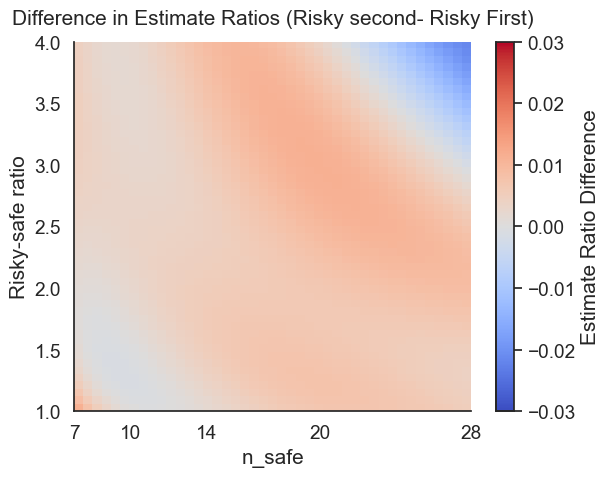

In [552]:
diff_diff = estimate_diff['safe_first'] - estimate_diff['risky_first']
plt.imshow(diff_diff, aspect='auto', origin='lower',
           extent=[xmin, xmax, ymin, ymax], cmap='coolwarm', vmin=-0.03, vmax=0.03)
plt.title('Difference in Estimate Ratios (Risky second- Risky First)', y=1.025)
plt.xlabel('n_safe')
plt.ylabel('Risky-safe ratio')
plt.xticks(n_safe_ticks)
plt.colorbar(label='Estimate Ratio Difference')
sns.despine()

plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/estimate_ratio_order_tms_difference.pdf', bbox_inches='tight')
plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/estimate_ratio_order_tms_difference.png', bbox_inches='tight', dpi=300)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_27475/1097711629.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tmp = df.pivot_table(index=['risky_first', 'risky_safe_bin_absolute'], columns=['stimulation_condition', 'n_safe'], values='chose_risky')


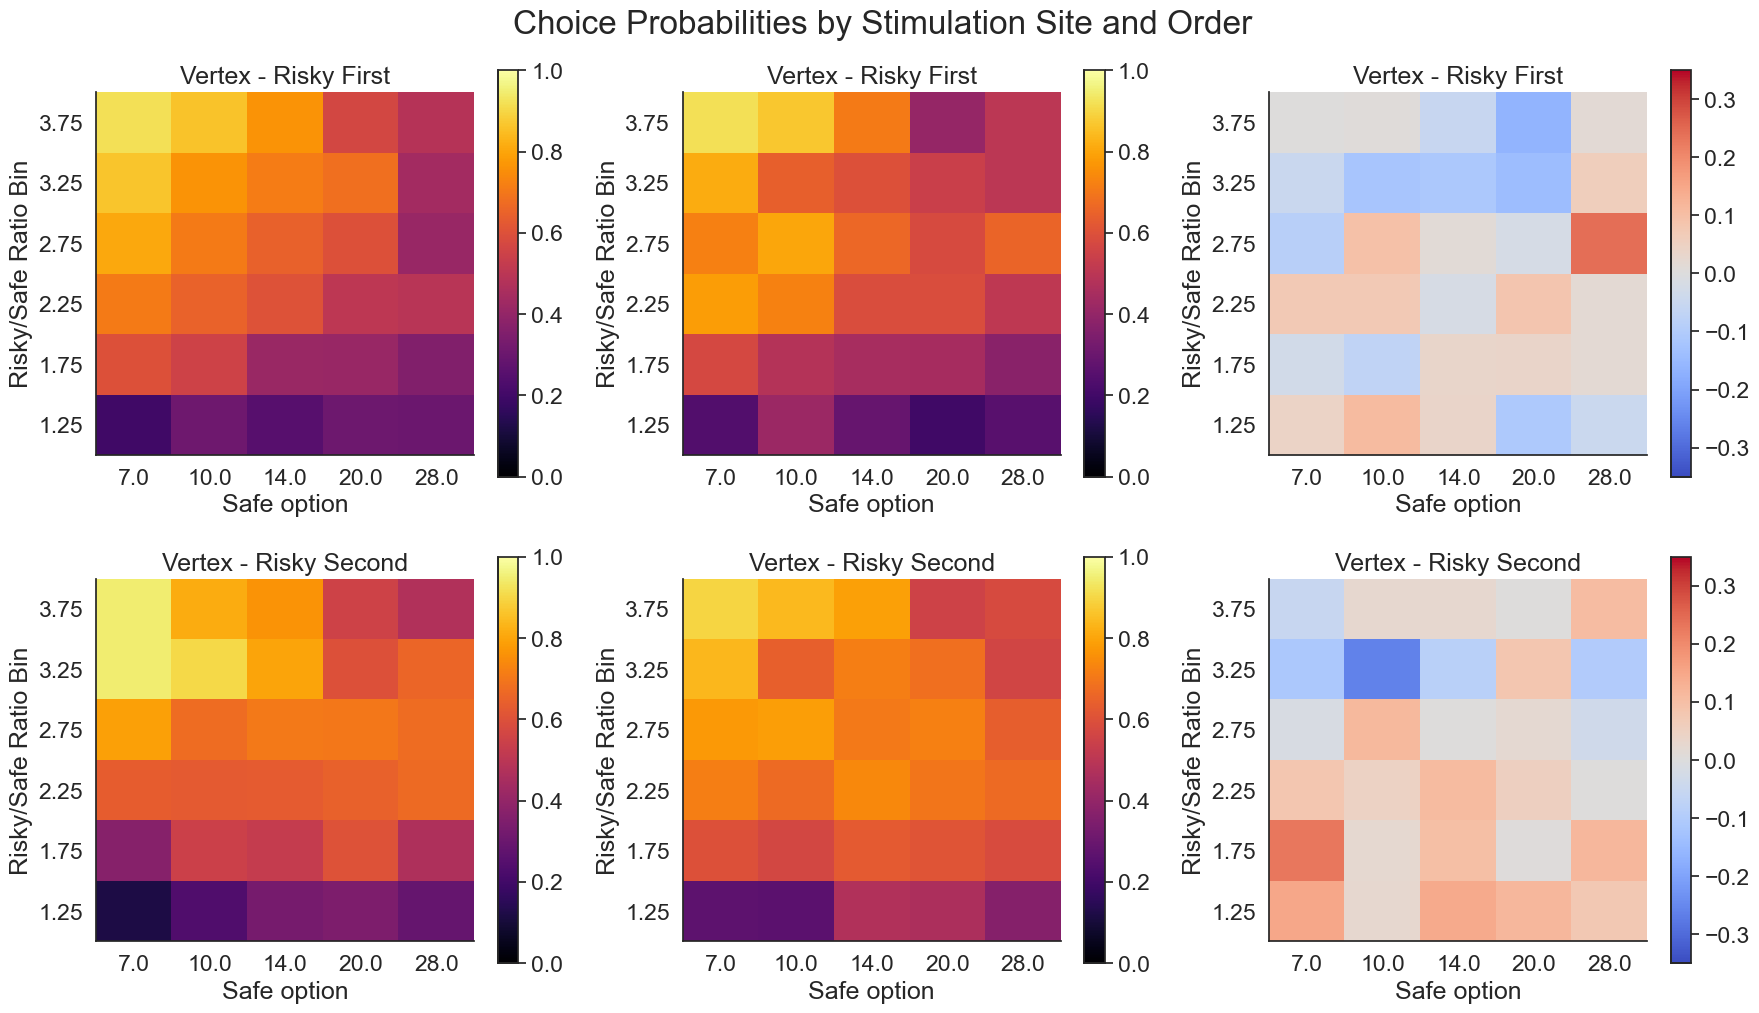

In [759]:
df['risky_safe_bin_absolute'] = pd.cut(df['n_risky']/df['n_safe'], bins=np.linspace(1, 4, 7), include_lowest=True).apply(lambda x: np.round(x.mid, 2))

tmp = df.pivot_table(index=['risky_first', 'risky_safe_bin_absolute'], columns=['stimulation_condition', 'n_safe'], values='chose_risky')

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

diff = {}

for j, risky_first in enumerate([True, False]):
    data = tmp.loc[risky_first]
    
    # Vertex
    ax = axes[j, 0]
    im1 = ax.imshow(data['vertex'], vmin=0, vmax=1, cmap='inferno', origin='lower', aspect=1/1.25)
    # Set axes logarithmic scale for x-axis

    ax.set_title(f'Vertex - {"Risky First" if risky_first else "Risky Second"}')
    fig.colorbar(im1, ax=ax)

    
    # IPS
    ax = axes[j, 1]
    im2 = ax.imshow(data['ips'], vmin=0, vmax=1, cmap='inferno', origin='lower', aspect=1/1.25)
    ax.set_title(f'Vertex - {"Risky First" if risky_first else "Risky Second"}')
    ax.set_xlabel('n_safe')
    ax.set_ylabel('Risky/Safe Ratio Bin')
    fig.colorbar(im2, ax=ax)
    
    # Difference
    ax = axes[j, 2]
    diff[risky_first] = data['ips'].values - data['vertex'].values
    im3 = ax.imshow(diff[risky_first], vmin=-0.35, vmax=0.35, cmap='coolwarm', origin='lower', aspect=1/1.25)
    ax.set_title(f'Vertex - {"Risky First" if risky_first else "Risky Second"}')
    ax.set_xlabel('n_safe')
    ax.set_ylabel('Risky/Safe Ratio')
    fig.colorbar(im3, ax=ax)

for ax in axes.flatten():
    ax.set_xticks(np.arange(len(data['vertex'].columns)))
    ax.set_xticklabels(data['vertex'].columns)
    ax.set_yticks(np.arange(len(data['vertex'].index)))
    ax.set_yticklabels(data['vertex'].index)
    ax.set_xlabel('Safe option')
    ax.set_ylabel('Risky/Safe Ratio Bin')

plt.tight_layout()
sns.despine()

plt.suptitle('Choice Probabilities by Stimulation Site and Order', fontsize=24, y=1.025)

plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/choice_probabilities_heatmaps.pdf', bbox_inches='tight')


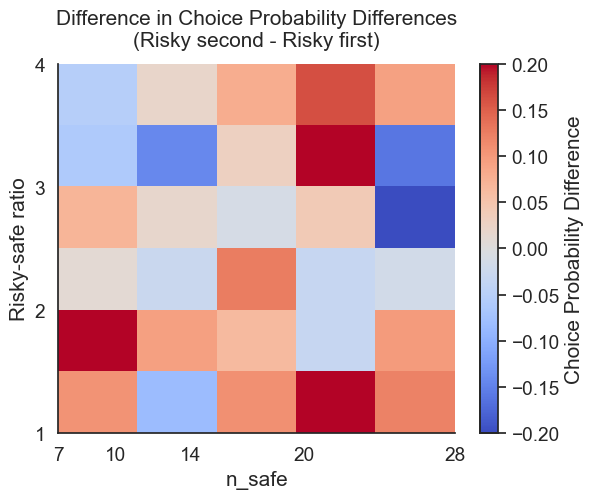

In [555]:
diff_diff = diff[False] - diff[True]
plt.imshow(diff_diff, aspect='auto', origin='lower',
           extent=[xmin, xmax, ymin, ymax], cmap='coolwarm', vmin=-0.2, vmax=0.2)
plt.title('Difference in Choice Probability Differences\n(Risky second - Risky first)', y=1.025)
plt.xlabel('n_safe')
plt.ylabel('Risky-safe ratio')
plt.xticks(n_safe_ticks)
plt.yticks(frac_ticks)
plt.colorbar(label='Choice Probability Difference')
sns.despine()

plt.savefig('/data/ds-tmsrisk/derivatives/figures/nov2025/choice_probability_difference_heatmap.pdf', bbox_inches='tight')

In [556]:
# Rename level 'x' to 'n_safe'
safe_curves_ = safe_curves.rename_axis(index={'x':'n_safe'})
safe_curves

variable                            memory_noise_sd  perceptual_noise_sd  \
subject stimulation_condition x                                            
1       ips                   7.0          0.781952             0.746024   
                              7.5          0.798631             0.756623   
                              8.0          0.815311             0.767223   
                              8.5          0.831886             0.778668   
                              9.0          0.848461             0.790113   
...                                             ...                  ...   
74      vertex                26.0         1.587830             1.702291   
                              26.5         1.594000             1.747153   
                              27.0         1.600170             1.792016   
                              27.5         1.606404             1.836855   
                              28.0         1.612639             1.881694   

variable                            n1_evidence_sd  n2_evidence_sd  all_noise  \
subject stimulation_condition x                                                 
1       ips                   7.0         1.527976        0.746024   1.714555   
                              7.5         1.555255        0.756623   1.743320   
                              8.0         1.582533        0.767223   1.772086   
                              8.5         1.610554        0.778668   1.801900   
                              9.0         1.638575        0.790113   1.831714   
...                                            ...             ...        ...   
74      vertex                26.0        3.290121        1.702291   3.710760   
                              26.5        3.341153        1.747153   3.776493   
                              27.0        3.392185        1.792016   3.842226   
                              27.5        3.443259        1.836855   3.908157   
                              28.0        3.494333        1.881694   3.974088   

variable                             prior_mu  prior_sd  
subject stimulation_condition x                          
1       ips                   7.0   14.638908  3.306074  
                              7.5   14.638908  3.306074  
                              8.0   14.638908  3.306074  
                              8.5   14.638908  3.306074  
                              9.0   14.638908  3.306074  
...                                       ...       ...  
74      vertex                26.0  15.784028  3.007444  
                              26.5  15.784028  3.007444  
                              27.0  15.784028  3.007444  
                              27.5  15.784028  3.007444  
                              28.0  15.784028  3.007444  

[3010 rows x 7 columns]

In [563]:
risky_curves

variable                                       memory_noise_sd  \
subject stimulation_condition n_safe frac                        
1       ips                   7.0    1.000000         0.781952   
                                     1.061224         0.796248   
                                     1.122449         0.810545   
                                     1.183673         0.824782   
                                     1.244898         0.838990   
...                                                        ...   
74      vertex                28.0   3.755102         2.196140   
                                     3.816327         2.146354   
                                     3.877551         2.091768   
                                     3.938776         2.033037   
                                     4.000000         1.970730   

variable                                       perceptual_noise_sd  \
subject stimulation_condition n_safe frac                            
1       ips                   7.0    1.000000             0.746024   
                                     1.061224             0.755109   
                                     1.122449             0.764194   
                                     1.183673             0.773763   
                                     1.244898             0.783573   
...                                                            ...   
74      vertex                28.0   3.755102             2.948841   
                                     3.816327             2.776680   
                                     3.877551             2.607794   
                                     3.938776             2.445322   
                                     4.000000             2.291778   

variable                                       n1_evidence_sd  n2_evidence_sd  \
subject stimulation_condition n_safe frac                                       
1       ips                   7.0    1.000000        1.527976        0.746024   
                                     1.061224        1.551358        0.755109   
                                     1.122449        1.574739        0.764194   
                                     1.183673        1.598545        0.773763   
                                     1.244898        1.622563        0.783573   
...                                                       ...             ...   
74      vertex                28.0   3.755102        5.144981        2.948841   
                                     3.816327        4.923034        2.776680   
                                     3.877551        4.699562        2.607794   
                                     3.938776        4.478359        2.445322   
                                     4.000000        4.262508        2.291778   

variable                                       all_noise   prior_mu  prior_sd  
subject stimulation_condition n_safe frac                                      
1       ips                   7.0    1.000000   1.714555  14.215032  4.132907  
                                     1.061224   1.739211  14.215032  4.132907  
                                     1.122449   1.763867  14.215032  4.132907  
                                     1.183673   1.789122  14.215032  4.132907  
                                     1.244898   1.814677  14.215032  4.132907  
...                                                  ...        ...       ...  
74      vertex                28.0   3.755102   5.953115  11.533790  2.952731  
                                     3.816327   5.681741  11.533790  2.952731  
                                     3.877551   5.411947  11.533790  2.952731  
                                     3.938776   5.148120  11.533790  2.952731  
                                     4.000000   4.893783  11.533790  2.952731  

[150500 rows x 7 columns]

In [564]:
risky_curves['percept1'], _ = get_posterior(risky_curves.index.get_level_values('n_safe').values * risky_curves.index.get_level_values('frac').values,
                                             risky_curves['n1_evidence_sd'],
                                             risky_curves['prior_mu'],
                                             risky_curves['prior_sd'])

risky_curves['percept2'], _ = get_posterior(risky_curves.index.get_level_values('n_safe').values * risky_curves.index.get_level_values('frac').values,
                                                risky_curves['n2_evidence_sd'], 
                                                risky_curves['prior_mu'],
                                                risky_curves['prior_sd'])

safe_curves['percept1'], _ = get_posterior(safe_curves.index.get_level_values('x').values,
                                           safe_curves['n1_evidence_sd'],
                                           safe_curves['prior_mu'],
                                           safe_curves['prior_sd'])

safe_curves['percept2'], _ = get_posterior(safe_curves.index.get_level_values('x').values,
                                           safe_curves['n2_evidence_sd'],
                                           safe_curves['prior_mu'],
                                           safe_curves['prior_sd'])

In [565]:
combined_curves = (risky_curves[['n1_evidence_sd', 'percept1', 'n2_evidence_sd', 'percept2']] * .55).join(safe_curves.rename_axis(index={'x':'n_safe'})[['percept1', 'n1_evidence_sd', 'percept2', 'n2_evidence_sd']], 
                                                                                lsuffix='_risky', rsuffix='_safe')


# Select only n_safe 7, 10, 14, 20, 28
combined_curves = combined_curves[combined_curves.index.get_level_values('n_safe').isin([7, 10, 14, 20, 28])]

combined_curves = combined_curves.groupby(['stimulation_condition', 'n_safe', 'frac']).mean()


combined_curves

variable                               n1_evidence_sd_risky  percept1_risky  \
stimulation_condition n_safe frac                                             
ips                   7.0    1.000000              1.061393        5.302453   
                             1.061224              1.071165        5.500458   
                             1.122449              1.080938        5.696970   
                             1.183673              1.090988        5.892485   
                             1.244898              1.101178        6.086692   
...                                                     ...             ...   
vertex                28.0   3.755102              4.069710       19.407875   
                             3.816327              4.129941       19.424689   
                             3.877551              4.194765       19.429778   
                             3.938776              4.264737       19.422297   
                             4.000000              4.340653       19.400633   

variable                               n2_evidence_sd_risky  percept2_risky  \
stimulation_condition n_safe frac                                             
ips                   7.0    1.000000              0.555978        4.353006   
                             1.061224              0.559277        4.572538   
                             1.122449              0.562576        4.791801   
                             1.183673              0.566205        5.011236   
                             1.244898              0.569998        5.230567   
...                                                     ...             ...   
vertex                28.0   3.755102              2.582123       27.611442   
                             3.816327              2.630530       27.671183   
                             3.877551              2.683989       27.698356   
                             3.938776              2.742885       27.690350   
                             4.000000              2.807831       27.642891   

variable                               percept1_safe  n1_evidence_sd_safe  \
stimulation_condition n_safe frac                                           
ips                   7.0    1.000000       8.213938             1.929805   
                             1.061224       8.213938             1.929805   
                             1.122449       8.213938             1.929805   
                             1.183673       8.213938             1.929805   
                             1.244898       8.213938             1.929805   
...                                              ...                  ...   
vertex                28.0   3.755102      20.170222             2.738698   
                             3.816327      20.170222             2.738698   
                             3.877551      20.170222             2.738698   
                             3.938776      20.170222             2.738698   
                             4.000000      20.170222             2.738698   

variable                               percept2_safe  n2_evidence_sd_safe  
stimulation_condition n_safe frac                                          
ips                   7.0    1.000000       7.576628             1.010868  
                             1.061224       7.576628             1.010868  
                             1.122449       7.576628             1.010868  
                             1.183673       7.576628             1.010868  
                             1.244898       7.576628             1.010868  
...                                              ...                  ...  
vertex                28.0   3.755102      24.777013             1.367251  
                             3.816327      24.777013             1.367251  
                             3.877551      24.777013             1.367251  
                             3.938776      24.777013             1.367251  
                             4

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_27475/2218601477.py:24: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  stacked = combined_curves.stack(['type', 'order'])


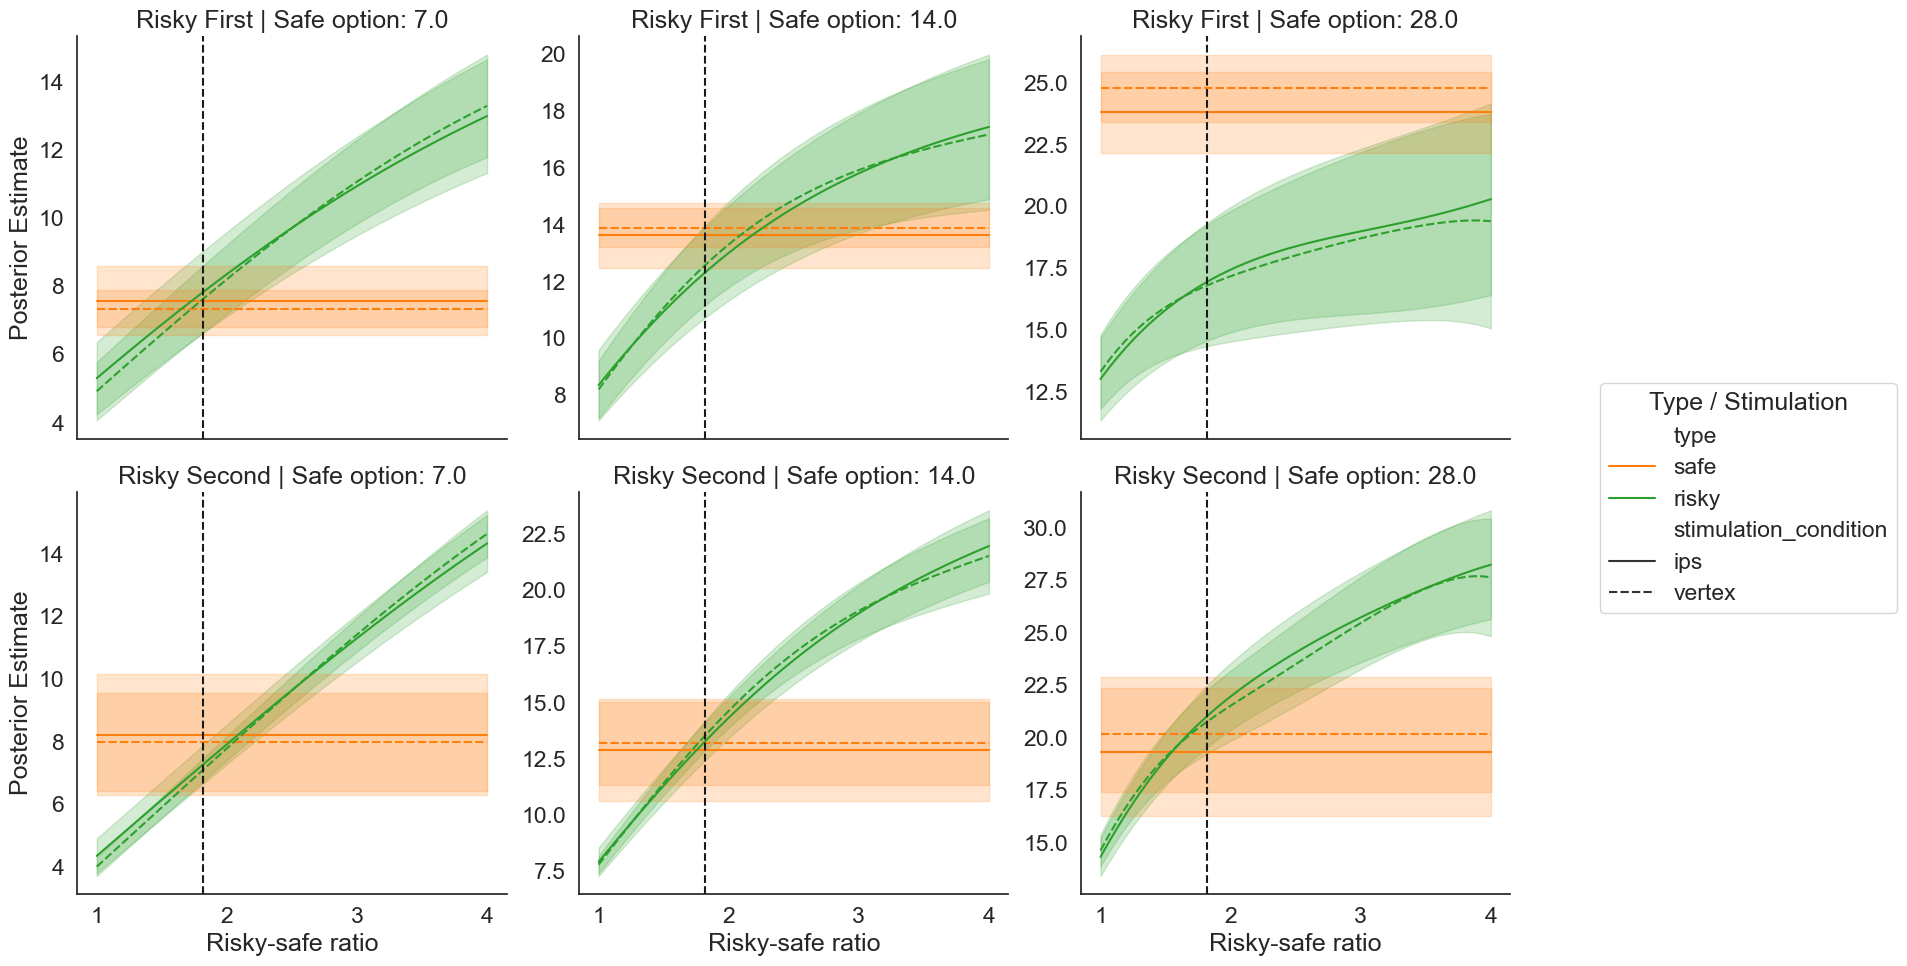

In [762]:
# Risky first
n_safe = 7.0

combined_curves = (risky_curves[['n1_evidence_sd', 'percept1', 'n2_evidence_sd', 'percept2']] * .55).join(safe_curves.rename_axis(index={'x':'n_safe'})[['n1_evidence_sd', 'percept1', 'n2_evidence_sd', 'percept2']], 
                                                                                lsuffix='_risky', rsuffix='_safe')

# combined_curves[['percept1_risky', 'percept2_risky']] *= .55


# Select only n_safe 7, 10, 14, 20, 28
combined_curves = combined_curves[combined_curves.index.get_level_values('n_safe').isin([7, 10, 14, 20, 28])]

combined_curves = combined_curves.groupby(['stimulation_condition', 'n_safe', 'frac']).mean()

# Create MultiIndex columns
combined_curves.columns = pd.MultiIndex.from_tuples([
    ('risky', 1, 'noise'), ('risky', 1, 'percept'),
    ('risky', 2, 'noise'), ('risky', 2, 'percept'),
    ('safe', 1, 'noise'), ('safe', 1, 'percept'),
    ('safe', 2, 'noise'), ('safe', 2, 'percept')
], names=['type', 'order', 'measure'])

# Stack to long format
stacked = combined_curves.stack(['type', 'order'])

# Riskyy first if index level order is 1 and type risky or when order is 2 and type safe, otherwise false
stacked['risky_first'] = ((stacked.index.get_level_values('order') == 1) & (stacked.index.get_level_values('type') == 'risky')) | \
                         ((stacked.index.get_level_values('order') == 2) & (stacked.index.get_level_values('type') == 'safe'))
# stacked = stacked.rename(columns={0: 'value'})


# Select only n-safe 7, 10, 14, 20, 28
stacked = stacked[stacked.index.get_level_values('n_safe').isin([7, 10, 14, 20, 28])]

stacked['min_noise'] = stacked['percept'] - stacked['noise']
stacked['max_noise'] = stacked['percept'] + stacked['noise']

stacked['Order'] = stacked['risky_first'].map({True: 'Risky First', False: 'Risky Second'})

g = sns.relplot(
    data=stacked[stacked.index.get_level_values('n_safe').isin([7, 14, 28])].reset_index(),
    x='frac', y='percept', kind='line',
    row='Order', col='n_safe',
    row_order=['Risky First', 'Risky Second'],
    hue='type', style='stimulation_condition',
    dashes=True, markers=False,
    height=5, aspect=1,
    palette={'risky': 'C2', 'safe': 'C1'},
    hue_order=['safe', 'risky'],
    facet_kws={'sharey': False},
)

# Remove the default legend
g._legend.remove()

# Create a new legend outside the plot
handles, labels = g.axes.flat[0].get_legend_handles_labels()
g.fig.legend(
    handles, labels,
    title='Type / Stimulation',
    bbox_to_anchor=(.9, .6),
    loc='upper left',
    borderaxespad=0.,
    frameon=True,
)

# Function to add shaded noise
def add_shaded_noise(data, ax, palette):
    for (type_, stim), d in data.groupby(['type', 'stimulation_condition']):
        ax.fill_between(
            d['frac'],
            d['percept'] - d['noise'],
            d['percept'] + d['noise'],
            color=palette[type_],
            alpha=0.2
        )

# Apply shaded noise to each facet
for (row_val, col_val), ax_data in stacked.reset_index().groupby(['Order', 'n_safe']):
    if col_val not in [7, 14, 28]:
        continue
    ax = g.axes_dict[(row_val, col_val)]
    add_shaded_noise(ax_data, ax, {'risky': 'C2', 'safe': 'C1'})

# Add vertical line and labels
g.set_axis_labels('Risky-safe ratio', 'Posterior Estimate')
g.set_titles(row_template='{row_name}', col_template='Safe option: {col_name}')
for ax in g.axes.flat:
    ax.axvline(x=1./.55, ls='--', c='k')

# Adjust the layout to prevent overlap
plt.tight_layout()
g.fig.subplots_adjust(right=0.85)  # Make space for the legend


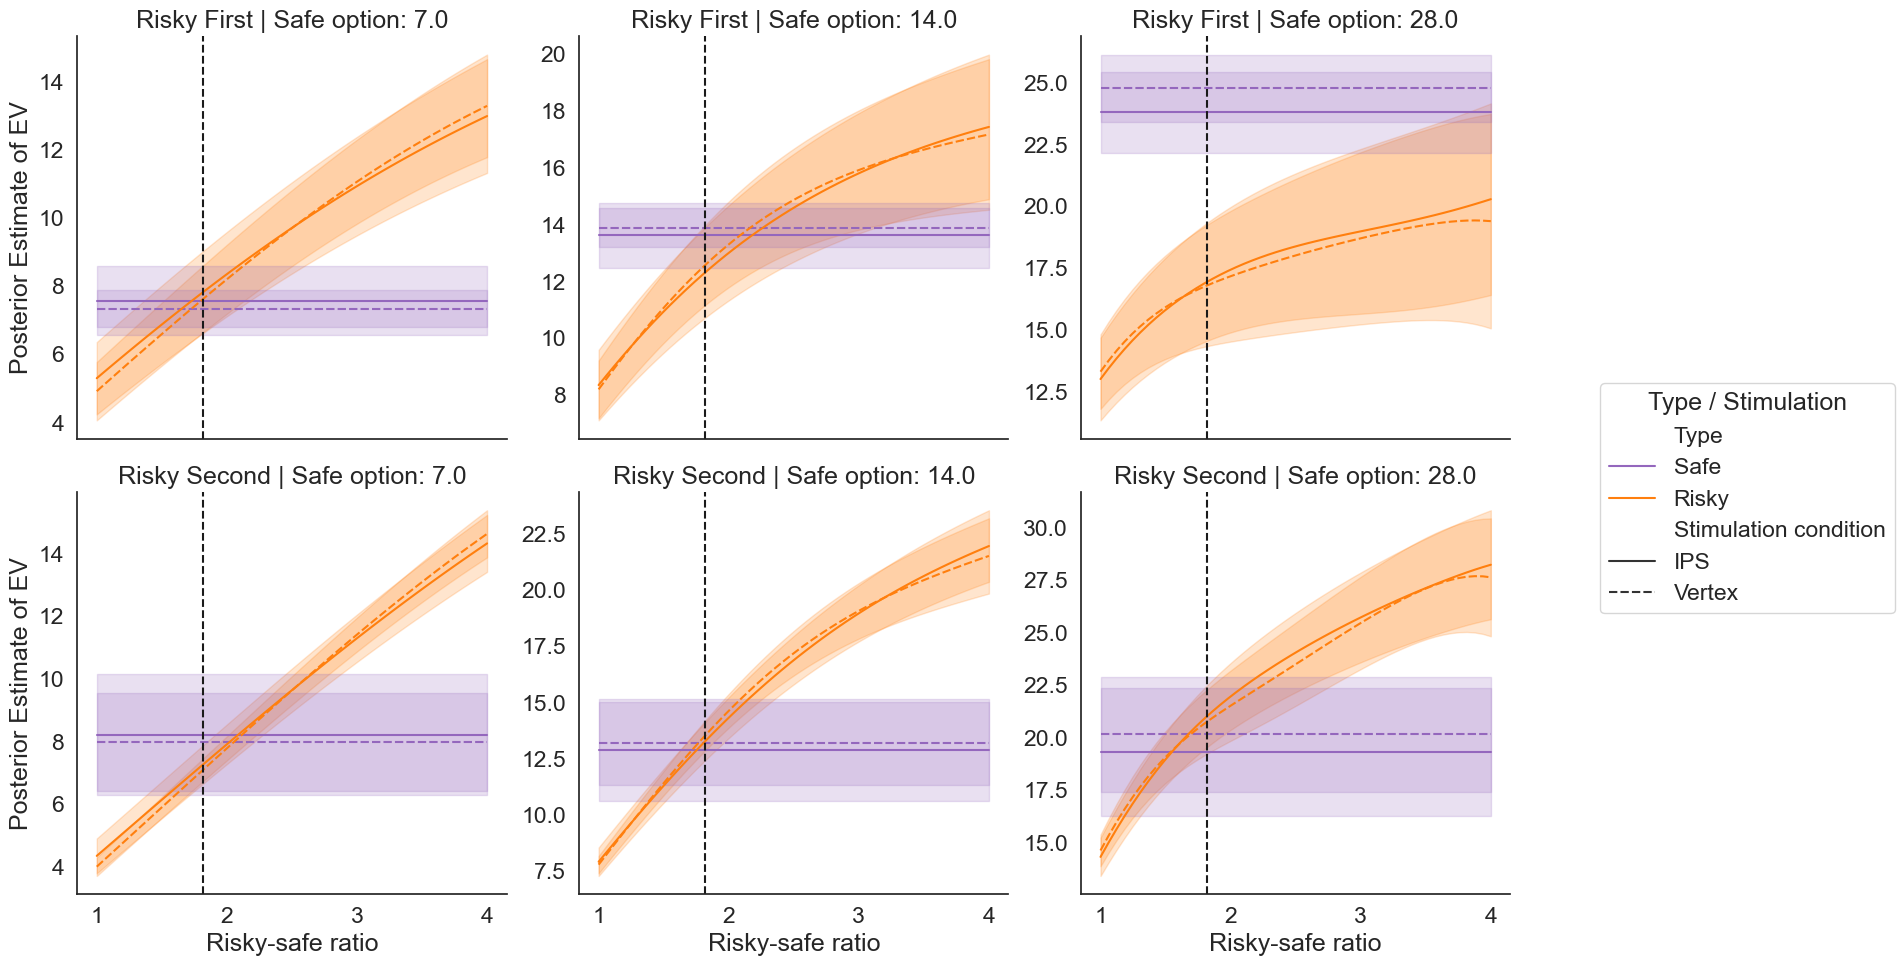

In [763]:
g = sns.relplot(
    data=stacked[stacked.index.get_level_values('n_safe').isin([7, 14, 28])].reset_index(),
    x='frac', y='percept', kind='line',
    row='Order', col='n_safe',
    row_order=['Risky First', 'Risky Second'],
    hue='type', style='stimulation_condition',
    dashes=True, markers=False,
    height=5, aspect=1,
    palette={'risky': 'C1', 'safe': 'C4'},
    hue_order=['safe', 'risky'],
    facet_kws={'sharey': False},
)

# Remove the default legend
g._legend.remove()

# Get handles and labels, and customize them
handles, labels = g.axes.flat[0].get_legend_handles_labels()
# # Split into hue and style handles/labels
# hue_handles = handles[:2]
# hue_labels = ['Safe', 'Risky']  # Customize as needed
# style_handles = handles[3:]
# style_labels[3:] = ['IPS', 'Vertex']

# # Combine handles and labels for the new legend
# all_handles = hue_handles + style_handles
# all_labels = hue_labels + style_labels
labels = ['Type', 'Safe', 'Risky', 'Stimulation condition', 'IPS', 'Vertex']
all_handles, all_labels = handles, labels

# Create a new legend outside the plot with clean titles
g.fig.legend(
    all_handles, all_labels,
    title='Type / Stimulation',
    bbox_to_anchor=(.9, .6),
    loc='upper left',
    borderaxespad=0.,
    frameon=True,
    ncol=1,  # Adjust as needed
)

# Function to add shaded noise
def add_shaded_noise(data, ax, palette):
    for (type_, stim), d in data.groupby(['type', 'stimulation_condition']):
        ax.fill_between(
            d['frac'],
            d['percept'] - d['noise'],
            d['percept'] + d['noise'],
            color=palette[type_],
            alpha=0.2
        )

# Apply shaded noise to each facet
for (row_val, col_val), ax_data in stacked.reset_index().groupby(['Order', 'n_safe']):
    if col_val not in [7, 14, 28]:
        continue
    ax = g.axes_dict[(row_val, col_val)]
    add_shaded_noise(ax_data, ax, {'risky': 'C1', 'safe': 'C4'})

# Add vertical line and labels
g.set_axis_labels('Risky-safe ratio', 'Posterior Estimate of EV')
g.set_titles(row_template='{row_name}', col_template='Safe option: {col_name}')
for ax in g.axes.flat:
    ax.axvline(x=1./.55, ls='--', c='k')

# Adjust the layout to prevent overlap
plt.tight_layout()
g.fig.subplots_adjust(right=0.85)  # Make space for the legend


In [764]:
# Stack to long format
stacked = combined_curves.stack(['type', 'order'])

# Riskyy first if index level order is 1 and type risky or when order is 2 and type safe, otherwise false
stacked['risky_first'] = ((stacked.index.get_level_values('order') == 1) & (stacked.index.get_level_values('type') == 'risky')) | \
                         ((stacked.index.get_level_values('order') == 2) & (stacked.index.get_level_values('type') == 'safe'))
# stacked = stacked.rename(columns={0: 'value'})


# # Select only n-safe 7, 10, 14, 20, 28
# stacked = stacked[stacked.index.get_level_values('n_safe').isin([7, 10, 14, 20, 28])]

# stacked['min_noise'] = stacked['percept'] - stacked['noise']
# stacked['max_noise'] = stacked['percept'] + stacked['noise']

# stacked


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_27475/388910139.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  stacked = combined_curves.stack(['type', 'order'])


In [765]:
tmp

stimulation_condition                     ips                                \
n_safe                                   7.0       10.0      14.0      20.0   
risky_first risky_safe_bin_absolute                                           
False       1.25                     0.266667  0.265060  0.473684  0.464789   
            1.75                     0.598425  0.568807  0.625000  0.610619   
            2.25                     0.717949  0.670588  0.739130  0.697917   
            2.75                     0.774194  0.785714  0.703704  0.720000   
            3.25                     0.837838  0.642857  0.717391  0.680000   
            3.75                     0.894737  0.842105  0.789474  0.552632   
True        1.25                     0.240000  0.418605  0.289474  0.197183   
            1.75                     0.571429  0.481481  0.451327  0.447368   
            2.25                     0.782051  0.724138  0.586957  0.589474   
            2.75                     0.721311  0.803571  0.660377  0.580000   
            3.25                     0.815789  0.642857  0.600000  0.540000   
            3.75                     0.921053  0.868421  0.710526  0.405405   

stimulation_condition                            vertex                      \
n_safe                                   28.0      7.0       10.0      14.0   
risky_first risky_safe_bin_absolute                                           
False       1.25                     0.363636  0.118421  0.238095  0.328947   
            1.75                     0.583333  0.370079  0.546296  0.526316   
            2.25                     0.670455  0.636364  0.625000  0.630435   
            2.75                     0.637931  0.790323  0.672727  0.703704   
            3.25                     0.560000  0.947368  0.904762  0.800000   
            3.75                     0.578947  0.947368  0.815789  0.763158   
True        1.25                     0.257576  0.197368  0.309524  0.253333   
            1.75                     0.375000  0.600000  0.551402  0.415929   
            2.25                     0.511364  0.710526  0.651163  0.604396   
            2.75                     0.655172  0.806452  0.709091  0.648148   
            3.25                     0.500000  0.864865  0.761905  0.711111   
            3.75                     0.500000  0.921053  0.861111  0.763158   

stimulation_condition                                    
n_safe                                   20.0      28.0  
risky_first risky_safe_bin_absolute                      
False       1.25                     0.347222  0.287879  
            1.75                     0.605263  0.466667  
            2.25                     0.645833  0.670455  
            2.75                     0.700000  0.672414  
            3.25                     0.600000  0.660000  
            3.75                     0.552632  0.473684  
True        1.25                     0.305556  0.303030  
            1.75                     0.410714  0.355932  
            2.25                     0.505263  0.494253  
            2.75                     0.600000  0.413793  
            3.25                     0.680000  0.440000  
            3.75                     0.567568  0.485714

In [766]:
df

session stimulation_condition        rt    n1    n2  \
subject run trial_nr                                                        
1       1   1               2                vertex  1.239692  28.0  86.0   
            2               2                vertex  0.836219   7.0  21.0   
            3               2                vertex  0.931371   7.0  21.0   
            4               2                vertex  1.135164  10.0  24.0   
            5               2                vertex  1.032161  20.0  44.0   
...                       ...                   ...       ...   ...   ...   
74      6   116             3                vertex  1.055890  37.0  20.0   
            117             3                vertex  0.739095  55.0  14.0   
            118             3                vertex  0.371731  22.0  20.0   
            119             3                vertex  0.705755  14.0  10.0   
            120             3                vertex  0.672241  15.0  14.0   

                        p1    p2  choice  risky_first  chose_risky  n_risky  \
subject run trial_nr                                                          
1       1   1         1.00  0.55    True        False         True     86.0   
            2         1.00  0.55    True        False         True     21.0   
            3         1.00  0.55    True        False         True     21.0   
            4         1.00  0.55   False        False        False     24.0   
            5         1.00  0.55   False        False        False     44.0   
...                    ...   ...     ...          ...          ...      ...   
74      6   116       0.55  1.00    True         True        False     37.0   
            117       0.55  1.00    True         True        False     55.0   
            118       0.55  1.00    True         True        False     22.0   
            119       0.55  1.00    True         True        False     14.0   
            120       0.55  1.00    True         True        False     15.0   

                      n_safe      frac  log(risky/safe)   log(n1)  \
subject run trial_nr                                                
1       1   1           28.0  3.071429         1.122143  3.332205   
            2            7.0  3.000000         1.098612  1.945910   
            3            7.0  3.000000         1.098612  1.945910   
            4           10.0  2.400000         0.875469  2.302585   
            5           20.0  2.200000         0.788457  2.995732   
...                      ...       ...              ...       ...   
74      6   116         20.0  1.850000         0.615186  3.610918   
            117         14.0  3.928571         1.368276  4.007333   
            118         20.0  1.100000         0.095310  3.091042   
            119         10.0  1.400000         0.336472  2.639057   
            120         14.0  1.071429         0.068993  2.708050   

                     bin(risky/safe)  bin(frac) risky_safe_bin_absolute  
subject run trial_nr                                                     
1       1   1                    80%       3.25                    3.25  
            2                    80%       2.75                    2.75  
            3                    80%       2.75                    2.75  
            4                    44%       2.25                    2.25  
            5                    44%       2.25                    2.25  
...                              ...        ...                     ...  
74      6   116                  44%       1.75                    1.75  
            117                  80%       3.75                    3.75  
            118                  20%       1.25                    1.25  
            119                  32%       1.25                    1.25  
            120                  20%       1.25                    1.25  

[8335 rows x 18 columns]

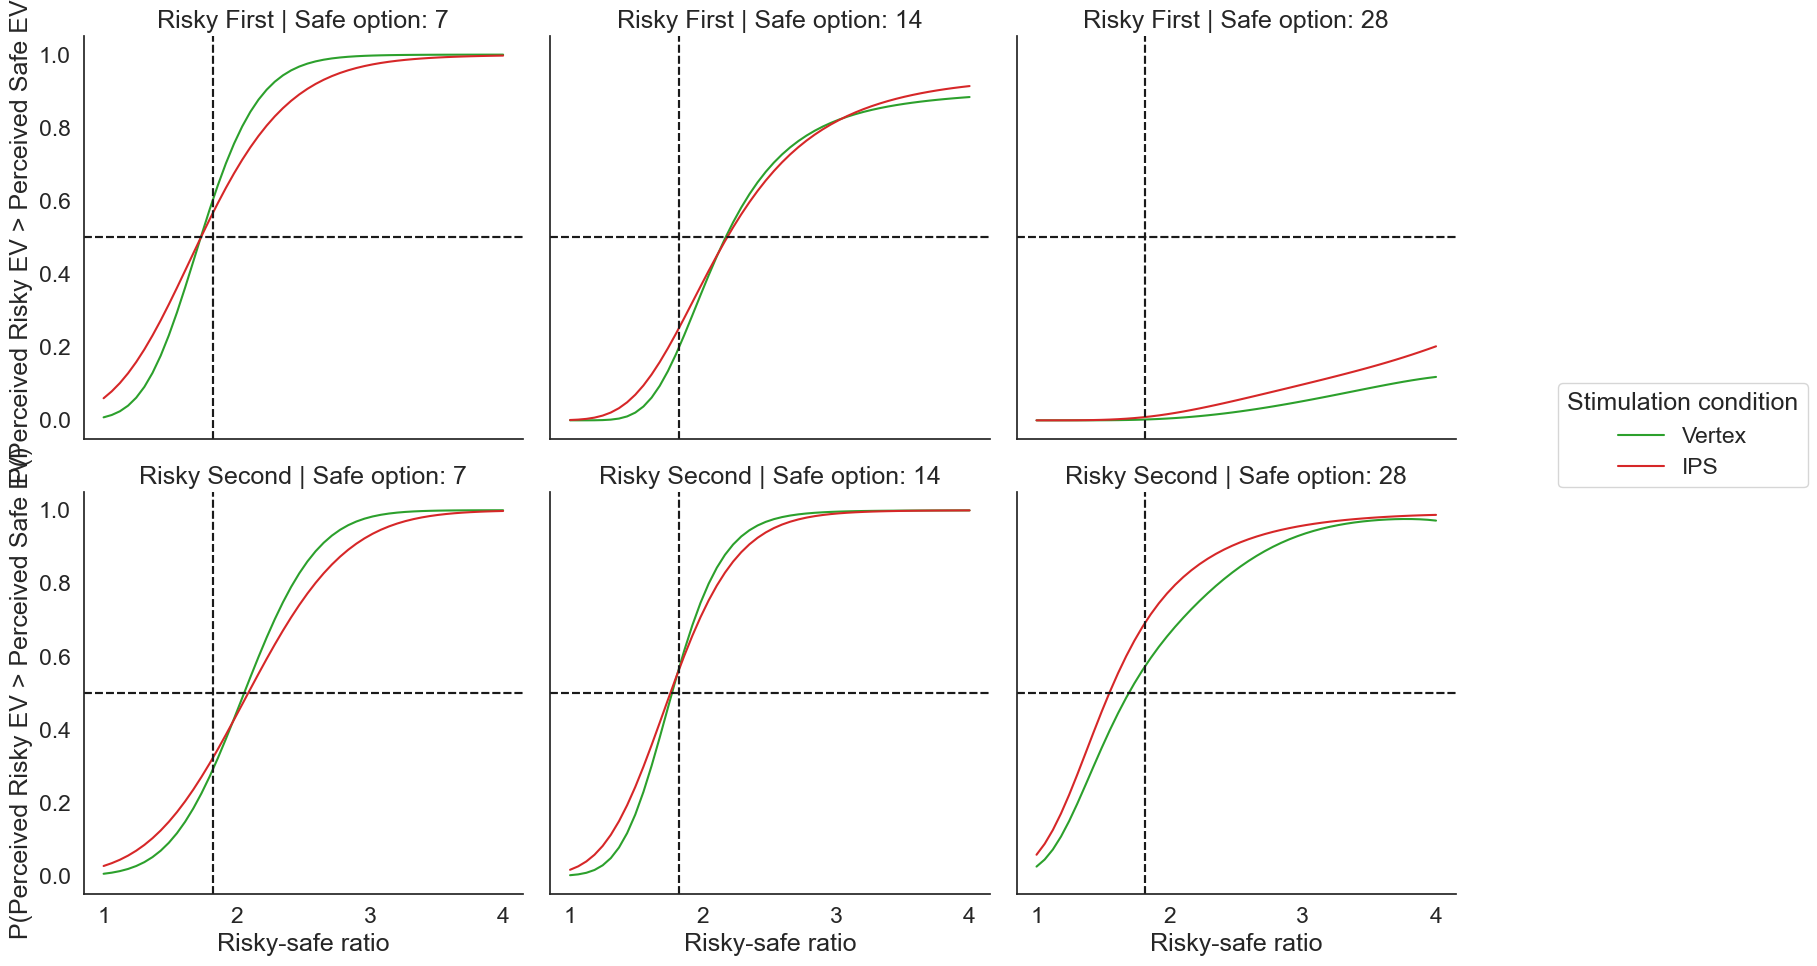

In [ ]:
from scipy.stats import norm

tmp = stacked.set_index('risky_first', append=True).droplevel('order').unstack('type')

tmp['Order'] = tmp.index.get_level_values('risky_first').map({True: 'Risky First', False: 'Risky Second'})

# tmp_risky_first = pd.concat(())

tmp['prob(risky>safe)'] = 1 - norm.cdf(0,
                                        tmp['percept']['risky'] - tmp['percept']['safe'],
                                        np.sqrt(tmp['noise']['risky']**2 + tmp['noise']['safe']**2))

g = sns.FacetGrid(row='Order', col='n_safe', data=tmp.reset_index(),
                  row_order=['Risky First', 'Risky Second'],
                  hue='stimulation_condition',
                  hue_order=['vertex', 'ips'],
                  palette=stimulation_palette,
                  col_order=[7, 14, 28],
                  height=5, aspect=1,)
g.map(sns.lineplot, 'frac', 'prob(risky>safe)')

g.set_axis_labels('Risky-safe ratio', 'P(Perceived Risky EV > Perceived Safe EV)')
g.set_titles(row_template='{row_name}', col_template='Safe option: {col_name}')

# g.add_legend()

g.map(plt.axhline, y=0.5, ls='--', c='k')
g.map(plt.axvline, x=1./.55, ls='--', c='k')


# Clean up legend
handles, labels = g.axes.flat[0].get_legend_handles_labels()
labels = ['Vertex', 'IPS']
g.fig.legend(
    handles, labels,
    title='Stimulation condition',
    bbox_to_anchor=(1.05, .6),
    loc='upper left',
    borderaxespad=0.,
    frameon=True,
    ncol=1,  # Adjust as needed
)

In [ ]:
from scipy.stats import norm

tmp = stacked.set_index('risky_first', append=True).droplevel('order').unstack('type')

tmp['Order'] = tmp.index.get_level_values('risky_first').map({True: 'Risky First', False: 'Risky Second'})

# tmp_risky_first = pd.concat(())

tmp['prob(risky>safe)'] = 1 - norm.cdf(0,
                                        tmp['percept']['risky'] - tmp['percept']['safe'],
                                        tmp['noise']['risky'] + tmp['noise']['safe'])
                                        # np.sqrt(tmp['noise']['risky']**2 + tmp['noise']['safe']**2))

g = sns.FacetGrid(row='Order', col='n_safe', data=tmp.reset_index(),
                  row_order=['Risky First', 'Risky Second'],
                  hue='stimulation_condition',
                  hue_order=['vertex', 'ips'],
                  palette=stimulation_palette,
                  col_order=[7, 10, 14, 20, 28],
                  height=5, aspect=1,)
g.map(sns.lineplot, 'frac', 'prob(risky>safe)')

g.set_axis_labels('Risky-safe ratio', 'P(Perceived Risky EV > Perceived Safe EV)')
g.set_titles(row_template='{row_name}', col_template='Safe option: {col_name}')

# g.add_legend()

g.map(plt.axhline, y=0.5, ls='--', c='k')
g.map(plt.axvline, x=1./.55, ls='--', c='k')


# Clean up legend
handles, labels = g.axes.flat[0].get_legend_handles_labels()
labels = ['Vertex', 'IPS']
g.fig.legend(
    handles, labels,
    title='Stimulation condition',
    bbox_to_anchor=(1.05, .6),
    loc='upper left',
    borderaxespad=0.,
    frameon=True,
    ncol=1,  # Adjust as needed
)

KeyError: 'Level Order not found'

/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


subject  bin(frac)  n_safe stimulation_condition  risky_first  \
0           1       1.66     7.0                   ips        False   
1           1       1.66     7.0                   ips         True   
2           1       1.66     7.0                vertex        False   
3           1       1.66     7.0                vertex         True   
4           1       1.66    10.0                   ips        False   
...       ...        ...     ...                   ...          ...   
2983       74       3.57    20.0                vertex         True   
2984       74       3.57    28.0                   ips        False   
2985       74       3.57    28.0                   ips         True   
2986       74       3.57    28.0                vertex        False   
2987       74       3.57    28.0                vertex         True   

      chose_risky  
0             0.5  
1             0.5  
2             0.0  
3             0.5  
4             0.0  
...           ...  
2983          1.0  
2984          1.0  
2985          0.5  
2986          1.0  
2987          1.0  

[2988 rows x 6 columns]

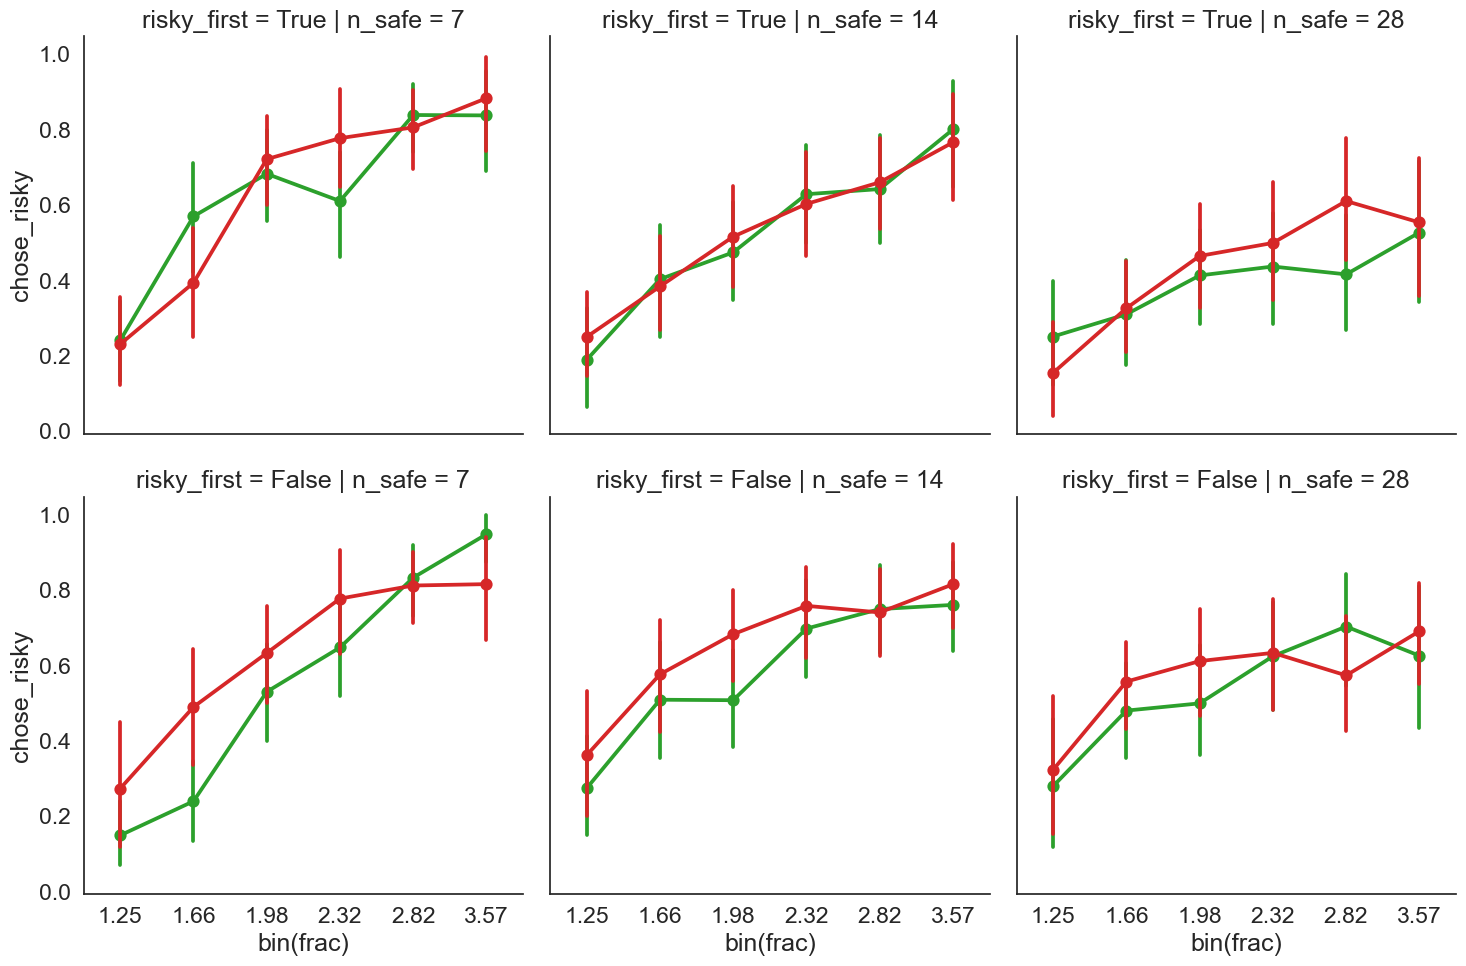

In [778]:
df['bin(frac)'] = pd.cut(df['frac'], bins=np.linspace(1.0, 4.0, 7), include_lowest=True).apply(lambda x: np.round(x.mid, 2)).astype(float)
df['bin(frac)'] = pd.qcut(df['frac'], q=6, duplicates='drop').apply(lambda x: np.round(x.mid, 2)).astype(float)
# tmp = df.groupby(['frac', 'n_safe', 'stimulation_condition', 'risky_first'])['chose_risky'].mean().reset_index()

tmp = df.groupby(['subject', 'bin(frac)', 'n_safe', 'stimulation_condition', 'risky_first'])['chose_risky'].mean().reset_index()

# drop nans
tmp = tmp.dropna()

g = sns.FacetGrid(row='risky_first', col='n_safe', data=tmp,
                  row_order=[True, False],
                  hue='stimulation_condition',
                  hue_order=['vertex', 'ips'],
                  palette=stimulation_palette,
                  col_order=[7, 14, 28],
                  height=5, aspect=1,)

g.map(sns.pointplot, 'bin(frac)', 'chose_risky', )

tmp


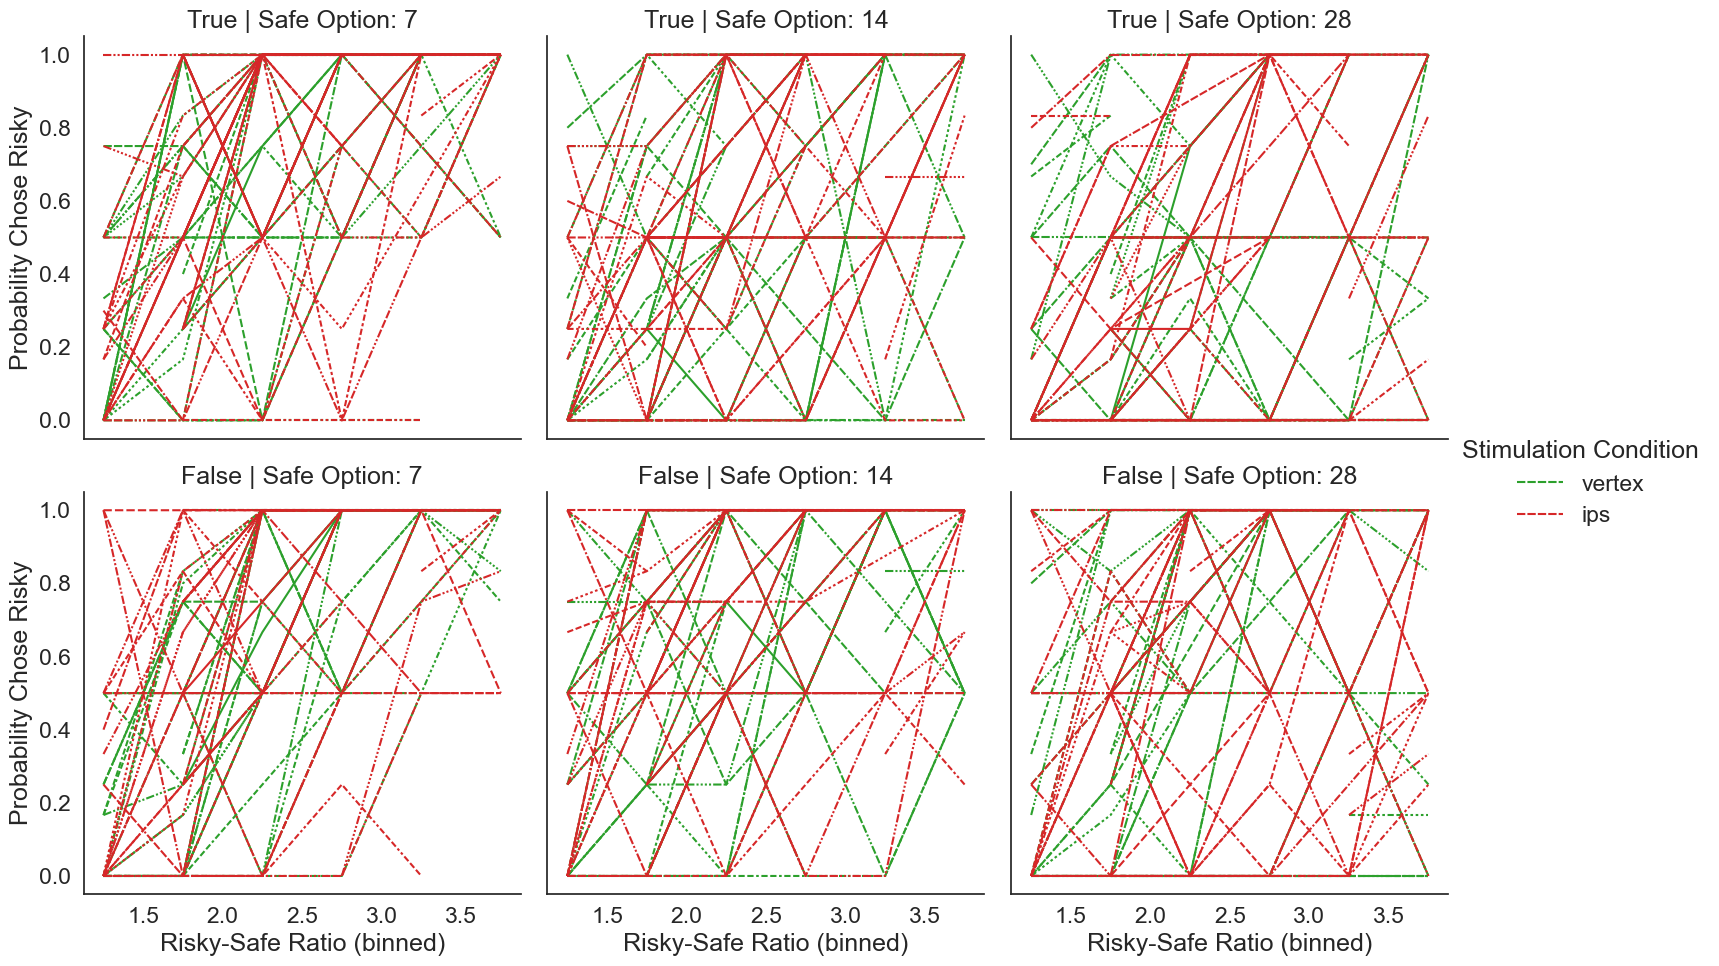

In [775]:
g = sns.FacetGrid(
    row='risky_first',
    col='n_safe',
    data=tmp,
    row_order=[True, False],
    hue='stimulation_condition',
    hue_order=['vertex', 'ips'],
    palette=stimulation_palette,
    col_order=[7, 14, 28],
    height=5,
    aspect=1,
)

g.map_dataframe(
    sns.lineplot,
    x='bin(frac)',
    y='chose_risky',
    style='subject',  # Differentiate by subject (optional)
    units='subject',  # Plot each subject as a separate line
    estimator=None,   # No aggregation
    lw=1.5,           # Thin lines
    legend=False,     # Disable auto-legend (we'll add it manually)
)

# Add a legend for stimulation condition only
g.add_legend(title='Stimulation Condition')

# Adjust labels and titles
g.set_axis_labels('Risky-Safe Ratio (binned)', 'Probability Chose Risky')
g.set_titles(row_template='{row_name}', col_template='Safe Option: {col_name}')


In [752]:
tmp.dtypes

subject                    int64
bin(frac)                float64
n_safe                   float64
stimulation_condition     object
risky_first                 bool
chose_risky              float64
dtype: object

In [746]:
tmp

subject bin(frac)  n_safe stimulation_condition  risky_first  \
0           1      1.25     7.0                   ips        False   
1           1      1.25     7.0                   ips         True   
2           1      1.25     7.0                vertex        False   
3           1      1.25     7.0                vertex         True   
4           1      1.25    10.0                   ips        False   
...       ...       ...     ...                   ...          ...   
4195       74      3.75    20.0                vertex         True   
4196       74      3.75    28.0                   ips        False   
4197       74      3.75    28.0                   ips         True   
4198       74      3.75    28.0                vertex        False   
4199       74      3.75    28.0                vertex         True   

      chose_risky  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
...           ...  
4195          1.0  
4196          1.0  
4197          0.5  
4198          1.0  
4199          1.0  

[4200 rows x 6 columns]

In [667]:
stacked

measure                                               noise    percept  \
stimulation_condition n_safe frac     type  order                        
ips                   7.0    1.000000 risky 1      1.061393   5.302453   
                                            2      0.555978   4.353006   
                                      safe  1      1.929805   8.213938   
                                            2      1.010868   7.576628   
                             1.061224 risky 1      1.071165   5.500458   
...                                                     ...        ...   
vertex                28.0   3.938776 safe  2      1.367251  24.777013   
                             4.000000 risky 1      4.340653  19.400633   
                                            2      2.807831  27.642891   
                                      safe  1      2.738698  20.170222   
                                            2      1.367251  24.777013   

measure                                            risky_first  min_noise  \
stimulation_condition n_safe frac     type  order                           
ips                   7.0    1.000000 risky 1             True   4.241060   
                                            2            False   3.797028   
                                      safe  1            False   6.284133   
                                            2             True   6.565760   
                             1.061224 risky 1             True   4.429293   
...                                                        ...        ...   
vertex                28.0   3.938776 safe  2             True  23.409762   
                             4.000000 risky 1             True  15.059981   
                                            2            False  24.835060   
                                      safe  1            False  17.431524   
                                            2             True  23.409762   

measure                                            max_noise  
stimulation_condition n_safe frac     type  order             
ips                   7.0    1.000000 risky 1       6.363846  
                                            2       4.908983  
                                      safe  1      10.143744  
                                            2       8.587496  
                             1.061224 risky 1       6.571624  
...                                                      ...  
vertex                28.0   3.938776 safe  2      26.144264  
                             4.000000 risky 1      23.741286  
                                            2      30.450722  
                                      safe  1      22.908920  
                                            2      26.144264  

[2000 rows x 5 columns]

In [642]:
stacked

measure                                               noise    percept  \
stimulation_condition n_safe frac     type  order                        
ips                   7.0    1.000000 risky 1      1.061393   5.302453   
                                            2      0.555978   4.353006   
                                      safe  1      1.929805   8.213938   
                                            2      1.010868   7.576628   
                             1.061224 risky 1      1.071165   5.500458   
...                                                     ...        ...   
vertex                28.0   3.938776 safe  2      1.367251  24.777013   
                             4.000000 risky 1      4.340653  19.400633   
                                            2      2.807831  27.642891   
                                      safe  1      2.738698  20.170222   
                                            2      1.367251  24.777013   

measure                                            risky_first  
stimulation_condition n_safe frac     type  order               
ips                   7.0    1.000000 risky 1             True  
                                            2            False  
                                      safe  1            False  
                                            2             True  
                             1.061224 risky 1             True  
...                                                        ...  
vertex                28.0   3.938776 safe  2             True  
                             4.000000 risky 1             True  
                                            2            False  
                                      safe  1            False  
                                            2             True  

[2000 rows x 3 columns]

In [573]:
combined_curves

type                                      risky                       \
order                                         1                    2   
measure                                   noise    percept     noise   
stimulation_condition n_safe frac                                      
ips                   7.0    1.000000  1.061393   5.302453  0.555978   
                             1.061224  1.071165   5.500458  0.559277   
                             1.122449  1.080938   5.696970  0.562576   
                             1.183673  1.090988   5.892485  0.566205   
                             1.244898  1.101178   6.086692  0.569998   
...                                         ...        ...       ...   
vertex                28.0   3.755102  4.069710  19.407875  2.582123   
                             3.816327  4.129941  19.424689  2.630530   
                             3.877551  4.194765  19.429778  2.683989   
                             3.938776  4.264737  19.422297  2.742885   
                             4.000000  4.340653  19.400633  2.807831   

type                                                  safe             \
order                                                    1              
measure                                  percept     noise    percept   
stimulation_condition n_safe frac                                       
ips                   7.0    1.000000   4.353006  1.929805   8.213938   
                             1.061224   4.572538  1.929805   8.213938   
                             1.122449   4.791801  1.929805   8.213938   
                             1.183673   5.011236  1.929805   8.213938   
                             1.244898   5.230567  1.929805   8.213938   
...                                          ...       ...        ...   
vertex                28.0   3.755102  27.611442  2.738698  20.170222   
                             3.816327  27.671183  2.738698  20.170222   
                             3.877551  27.698356  2.738698  20.170222   
                             3.938776  27.690350  2.738698  20.170222   
                             4.000000  27.642891  2.738698  20.170222   

type                                                        
order                                         2             
measure                                   noise    percept  
stimulation_condition n_safe frac                           
ips                   7.0    1.000000  1.010868   7.576628  
                             1.061224  1.010868   7.576628  
                             1.122449  1.010868   7.576628  
                             1.183673  1.010868   7.576628  
                             1.244898  1.010868   7.576628  
...                                         ...        ...  
vertex                28.0   3.755102  1.367251  24.777013  
                             3.816327  1.367251  24.777013  
                             3.877551  1.367251  24.777013  
                             3.938776  1.367251  24.777013  
                             4.000000  1.367251  24.777013  

[500 rows x 8 columns]

In [631]:
combined_curves

type                                      risky                       \
order                                         1                    2   
measure                                   noise    percept     noise   
stimulation_condition n_safe frac                                      
ips                   7.0    1.000000  1.061393   5.302453  0.555978   
                             1.061224  1.071165   5.500458  0.559277   
                             1.122449  1.080938   5.696970  0.562576   
                             1.183673  1.090988   5.892485  0.566205   
                             1.244898  1.101178   6.086692  0.569998   
...                                         ...        ...       ...   
vertex                28.0   3.755102  4.069710  19.407875  2.582123   
                             3.816327  4.129941  19.424689  2.630530   
                             3.877551  4.194765  19.429778  2.683989   
                             3.938776  4.264737  19.422297  2.742885   
                             4.000000  4.340653  19.400633  2.807831   

type                                                  safe             \
order                                                    1              
measure                                  percept     noise    percept   
stimulation_condition n_safe frac                                       
ips                   7.0    1.000000   4.353006  1.929805   8.213938   
                             1.061224   4.572538  1.929805   8.213938   
                             1.122449   4.791801  1.929805   8.213938   
                             1.183673   5.011236  1.929805   8.213938   
                             1.244898   5.230567  1.929805   8.213938   
...                                          ...       ...        ...   
vertex                28.0   3.755102  27.611442  2.738698  20.170222   
                             3.816327  27.671183  2.738698  20.170222   
                             3.877551  27.698356  2.738698  20.170222   
                             3.938776  27.690350  2.738698  20.170222   
                             4.000000  27.642891  2.738698  20.170222   

type                                                        
order                                         2             
measure                                   noise    percept  
stimulation_condition n_safe frac                           
ips                   7.0    1.000000  1.010868   7.576628  
                             1.061224  1.010868   7.576628  
                             1.122449  1.010868   7.576628  
                             1.183673  1.010868   7.576628  
                             1.244898  1.010868   7.576628  
...                                         ...        ...  
vertex                28.0   3.755102  1.367251  24.777013  
                             3.816327  1.367251  24.777013  
                             3.877551  1.367251  24.777013  
                             3.938776  1.367251  24.777013  
                             4.000000  1.367251  24.777013  

[500 rows x 8 columns]

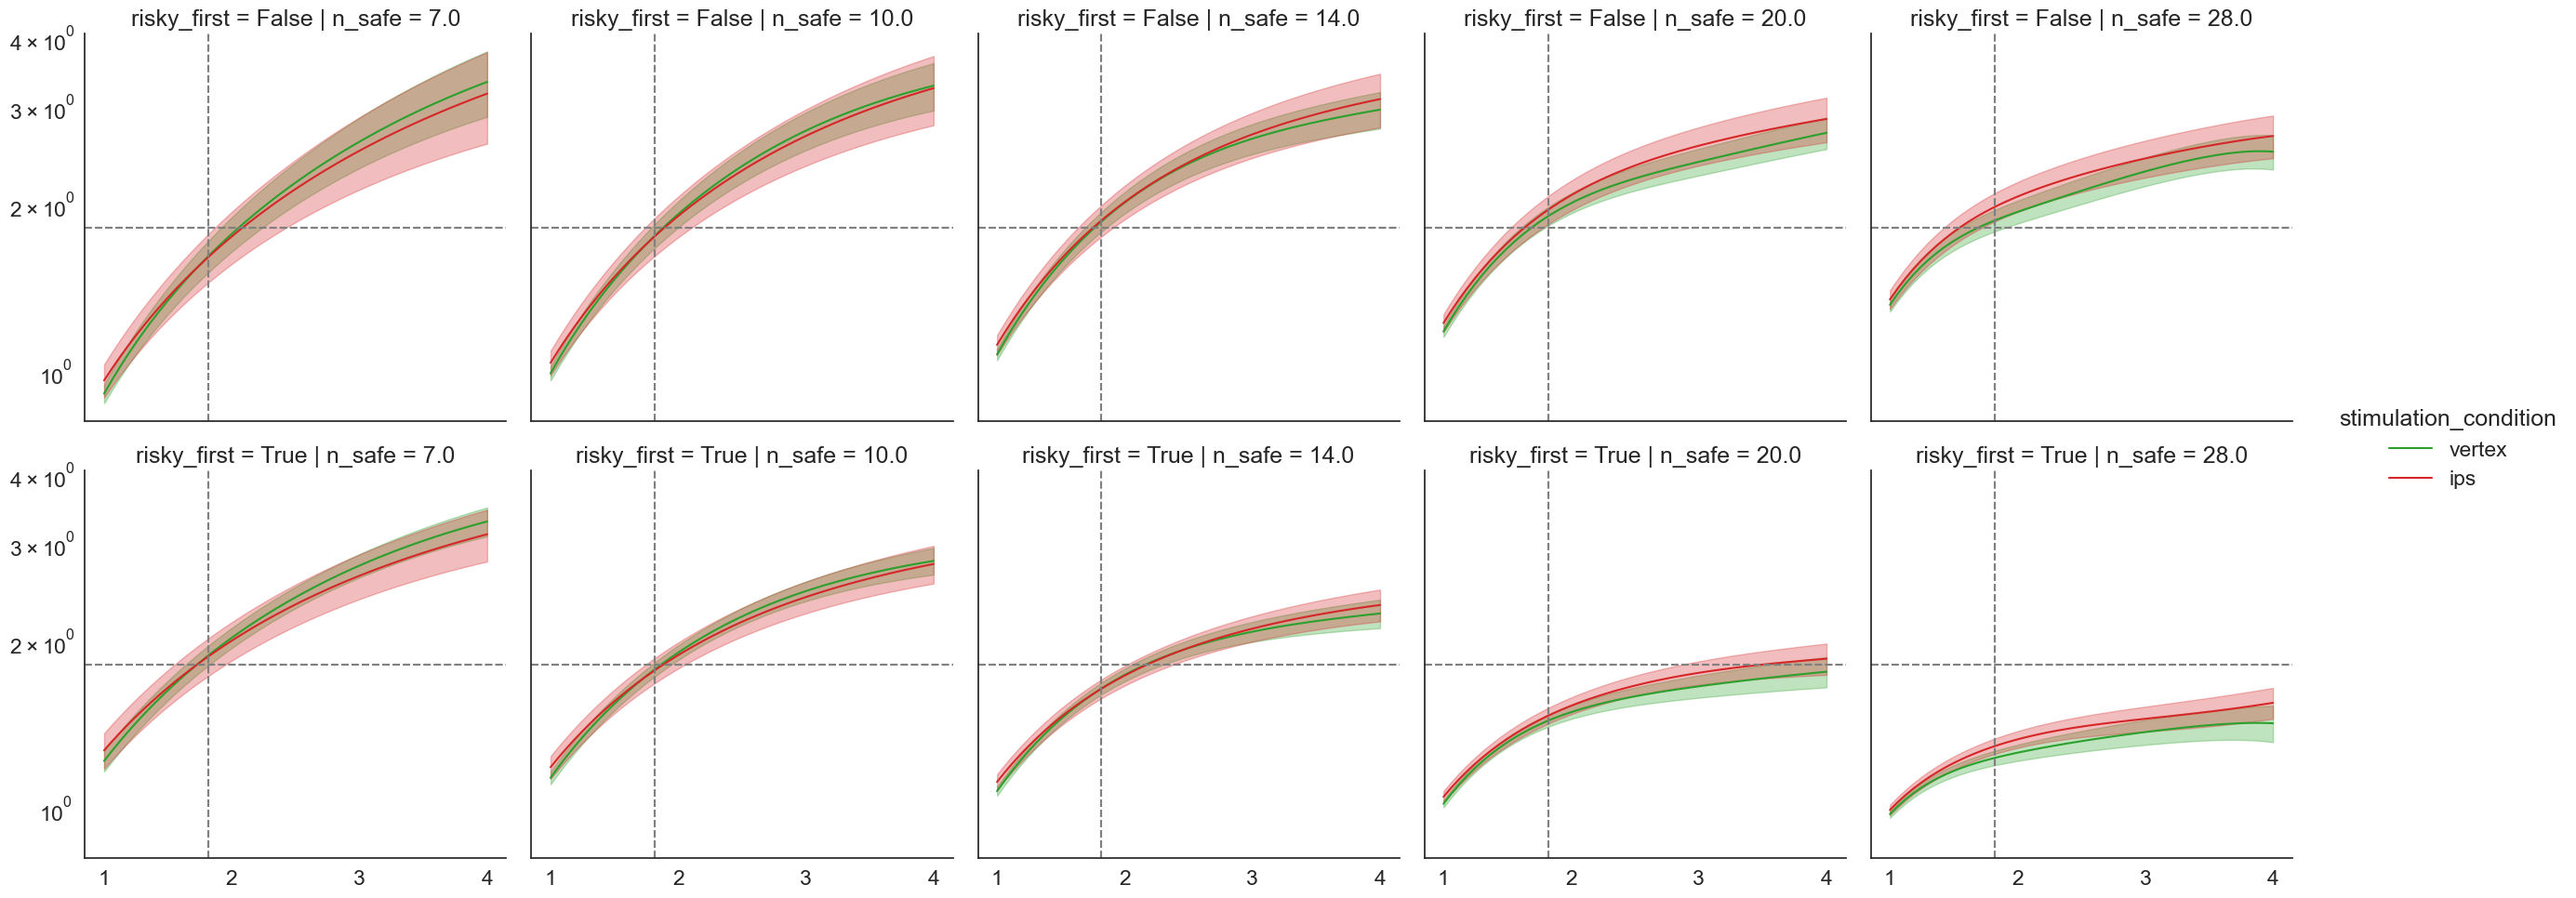

In [637]:
ratio_risky_first = combined_curves[('risky', 1, 'percept')] * (1./.55) / combined_curves[('safe', 2, 'percept')]
ratio_safe_first = combined_curves[('risky', 2, 'percept')] * (1./.55) / combined_curves[('safe', 1, 'percept')]

sd_risky_first = ratio_risky_first**2  * ((combined_curves[('risky', 1, 'noise')] / combined_curves[('risky', 1, 'percept')])**2 +
                                         (combined_curves[('safe', 2, 'noise')] / combined_curves[('safe', 2, 'percept')])**2)

sd_safe_first = ratio_safe_first**2  * ((combined_curves[('risky', 2, 'noise')] / combined_curves[('risky', 2, 'percept')])**2 +
                                       (combined_curves[('safe', 1, 'noise')] / combined_curves [('safe', 1, 'percept')])**2)



ratio = pd.DataFrame({
    'ratio': np.concatenate([ratio_risky_first.values, ratio_safe_first.values]),
    'ratio_noise': np.concatenate([sd_risky_first.values, sd_safe_first.values]),
    'risky_first': [True]*len(ratio_risky_first) + [False]*len(ratio_safe_first),
    'n_safe': np.concatenate([ratio_risky_first.index.get_level_values('n_safe').values,
                              ratio_safe_first.index.get_level_values('n_safe').values]),
    'frac': np.concatenate([ratio_risky_first.index.get_level_values('frac').values,
                            ratio_safe_first.index.get_level_values('frac').values]),
    'stimulation_condition': np.concatenate([ratio_risky_first.index.get_level_values('stimulation_condition').values,
                                            ratio_safe_first.index.get_level_values('stimulation_condition').values])
})

# g = sns.relplot(data=ratio, x='frac', y='ratio', hue='stimulation_condition', col='n_safe', row='risky_first', kind='line', height=5, aspect=1,
#                 hue_order=['vertex', 'ips'], style='stimulation_condition', palette=stimulation_palette)

def plot_prediction(data, **kwargs):
    # Extract the color from kwargs (passed by FacetGrid)
    color = kwargs.get('color')
    # Extract the label from the data (hue variable)
    label = data.name if hasattr(data, 'name') else kwargs.get('label')
    # Sort the data
    data = data.sort_values('frac')
    # Fill between
    plt.fill_between(data['frac'],
                     data['ratio'] - data['ratio_noise'],
                     data['ratio'] + data['ratio_noise'],
                     color=color, alpha=0.3)
    # Plot with label
    plt.plot(data['frac'], data['ratio'], color=color, label=label)

# Create the FacetGrid
g = sns.FacetGrid(ratio, row='risky_first', col='n_safe', height=5, aspect=1, hue='stimulation_condition', palette=stimulation_palette, hue_order=['vertex', 'ips'])
# Map the function, and let FacetGrid handle the color and label
g.map_dataframe(plot_prediction)
# Add the legend
g.add_legend()

g.map(plt.axhline, y=1./.55, ls='--', c='gray')
g.map(plt.axvline, x=1./.55, ls='--', c='gray')

# g.set(ylim=(.75, 1.4))

# Make y-axis log scale
g.set(yscale='log')

In [373]:
stacked.xs(20.0, level='n_safe')

measure                                         noise    percept  risky_first
stimulation_condition frac     type  order                                   
ips                   1.000000 risky 1       2.577528  19.291674         True
                                     2       1.338311  19.697818        False
                               safe  1      16.106559   2.577528        False
                                     2      18.392514   1.338311         True
                      1.061224 risky 1       2.646886  20.039314         True
...                                               ...        ...          ...
vertex                3.938776 safe  2      19.094679   0.935788         True
                      4.000000 risky 1       6.146151  33.674748         True
                                     2       3.892213  45.307314        False
                               safe  1      16.813066   2.182514        False
                                     2      19.094679   0.935788         True

[400 rows x 3 columns]

In [367]:
stacked

measure                                                noise    percept
stimulation_condition n_safe frac     type  order                      
ips                   7.0    1.000000 risky 1       1.929805   9.640824
                                            2       1.010868   7.914556
                                      safe  1       8.213938   1.929805
                                            2       7.576628   1.010868
                             1.061224 risky 1       1.947574  10.000833
...                                                      ...        ...
vertex                28.0   3.938776 safe  2      24.777013   1.367251
                             4.000000 risky 1       7.892096  35.273879
                                            2       5.105147  50.259801
                                      safe  1      20.170222   2.738698
                                            2      24.777013   1.367251

[2000 rows x 2 columns]

In [ ]:
# Start with your combined DataFrame
combined_curves = risky_curves[['n1_evidence_sd', 'percept1', 'n2_evidence_sd', 'percept2']].join(
    safe_curves.rename_axis(index={'x': 'n_safe'})[['percept1', 'n1_evidence_sd', 'percept2', 'n2_evidence_sd']],
    lsuffix='_risky', rsuffix='_safe'
)

# Filter for specific n_safe values
combined_curves = combined_curves[
    combined_curves.index.get_level_values('n_safe').isin([7, 10, 14, 20, 28])
].groupby(['stimulation_condition', 'n_safe', 'frac']).mean()

# Melt to long format in one step
stacked = combined_curves.reset_index().melt(
    id_vars=['stimulation_condition', 'n_safe', 'frac'],
    var_name='variable',='value'
)

# Split 'variable' into type, order, and measure
stacked[['measure', 'type_order']] = stacked['variable'].str.rsplit('_', n=1, expand=True)
stacked[['order', 'type']] = stacked['type_order'].str.extract(r'(\d+)_?(risky|safe)')
stacked['order'] = stacked['order'].astype(int)

# Clean up
stacked = stacked.drop(columns=['variable', 'type_order'])
stacked['measure'] = stacked['measure'].str.replace('n\d+_evidence_sd', 'noise').str.replace('percept', 'percept')

# Final DataFrame with columns:
# ['stimulation_condition', 'n_safe', 'frac', 'type', 'order', 'measure', 'value']


ValueError: cannot convert float NaN to integer

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_27475/2406409268.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  percept_data['parameter'] = percept_data['parameter'].str.replace('_percept', '')
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_27475/2406409268.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noise_data['parameter'] = noise_data['parameter'].str.replace('_noise', '')


ValueError: 'x' has size 100, but 'y1' has an unequal size of 3500

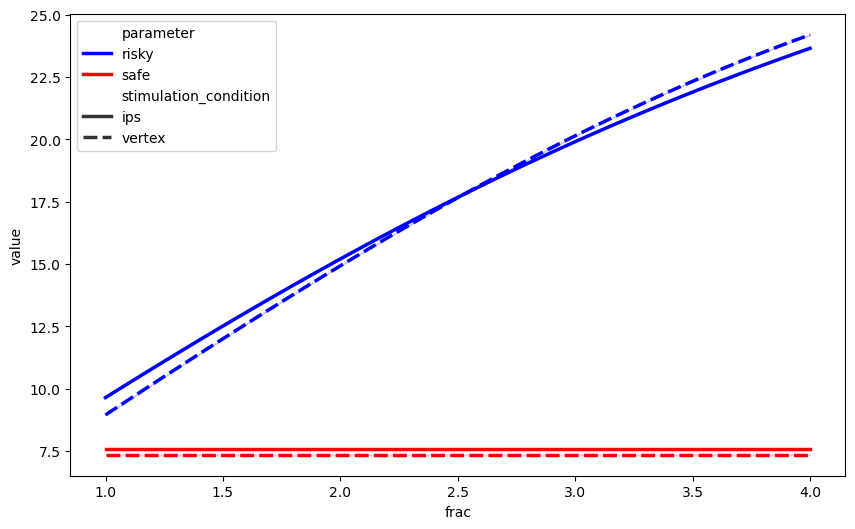

In [326]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Data Preparation ---
n_safe = 7.0
safe_percept = safe_estimates_risky_first.xs(n_safe, level='x').to_frame('safe_percept')
safe_noise = safe_curves.xs(n_safe, level='x')['n2_evidence_sd'].rename('safe_noise')
risky_percept = risky_estimates_risky_first.xs(n_safe, level='n_safe').to_frame('risky_percept')
risky_noise = risky_curves.xs(n_safe, level='n_safe')['n1_evidence_sd'].rename('risky_noise')
frac = risky_percept.index.get_level_values('frac')

# Combine all data
percepts = risky_percept.join(risky_noise).join(safe_percept).join(safe_noise)
percepts = percepts.reset_index().rename(columns={'index': 'stimulation_condition'})

# Melt for plotting
percepts_long = pd.melt(
    percepts,
    id_vars=['stimulation_condition', 'frac'],
    value_vars=['risky_percept', 'safe_percept', 'risky_noise', 'safe_noise'],
    var_name='parameter',
    value_name='value'
)

# Separate percepts and noise
percept_data = percepts_long[percepts_long['parameter'].isin(['risky_percept', 'safe_percept'])]
noise_data = percepts_long[percepts_long['parameter'].isin(['risky_noise', 'safe_noise'])]

# Rename for clarity
percept_data['parameter'] = percept_data['parameter'].str.replace('_percept', '')
noise_data['parameter'] = noise_data['parameter'].str.replace('_noise', '')

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Plot percept lines
sns.lineplot(
    data=percept_data,
    x='frac',
    y='value',
    hue='parameter',
    style='stimulation_condition',
    palette=['blue', 'red'],
    linewidth=2.5
)

# Add shaded error regions
for cond in ['risky', 'safe']:
    cond_percept = percepts[f'{cond}_percept']
    cond_noise = percepts[f'{cond}_noise']
    plt.fill_between(
        frac,
        cond_percept - cond_noise,
        cond_percept + cond_noise,
        alpha=0.2,
        color='blue' if cond == 'safe' else 'red'
    )

plt.xlabel('Risky-Safe Ratio (frac)')
plt.ylabel('Percept')
plt.title(f'Percept vs. Frac (n_safe = {n_safe})')
plt.grid(True)
plt.show()


In [324]:
risky_percept

stimulation_condition  frac    
ips                    1.000000     9.640824
                       1.061224    10.000833
                       1.122449    10.358128
                       1.183673    10.713610
                       1.244898    11.066713
                                     ...    
vertex                 3.755102    23.317841
                       3.816327    23.543776
                       3.877551    23.765079
                       3.938776    23.981446
                       4.000000    24.193550
Name: percept, Length: 100, dtype: float64

In [289]:
safe_curves

variable                            memory_noise_sd  perceptual_noise_sd  \
subject stimulation_condition x                                            
1       ips                   7.0          0.781952             0.746024   
                              7.5          0.798631             0.756623   
                              8.0          0.815311             0.767223   
                              8.5          0.831886             0.778668   
                              9.0          0.848461             0.790113   
...                                             ...                  ...   
74      vertex                26.0         1.587830             1.702291   
                              26.5         1.594000             1.747153   
                              27.0         1.600170             1.792016   
                              27.5         1.606404             1.836855   
                              28.0         1.612639             1.881694   

variable                            n1_evidence_sd  n2_evidence_sd  all_noise  \
subject stimulation_condition x                                                 
1       ips                   7.0         1.527976        0.746024   1.714555   
                              7.5         1.555255        0.756623   1.743320   
                              8.0         1.582533        0.767223   1.772086   
                              8.5         1.610554        0.778668   1.801900   
                              9.0         1.638575        0.790113   1.831714   
...                                            ...             ...        ...   
74      vertex                26.0        3.290121        1.702291   3.710760   
                              26.5        3.341153        1.747153   3.776493   
                              27.0        3.392185        1.792016   3.842226   
                              27.5        3.443259        1.836855   3.908157   
                              28.0        3.494333        1.881694   3.974088   

variable                            prior_mu"   prior_mu  prior_sd  
subject stimulation_condition x                                     
1       ips                   7.0         NaN  14.638908  3.306074  
                              7.5         NaN  14.638908  3.306074  
                              8.0         NaN  14.638908  3.306074  
                              8.5         NaN  14.638908  3.306074  
                              9.0         NaN  14.638908  3.306074  
...                                       ...        ...       ...  
74      vertex                26.0        NaN  15.784028  3.007444  
                              26.5        NaN  15.784028  3.007444  
                              27.0        NaN  15.784028  3.007444  
                              27.5        NaN  15.784028  3.007444  
                              28.0        NaN  15.784028  3.007444  

[3010 rows x 8 columns]

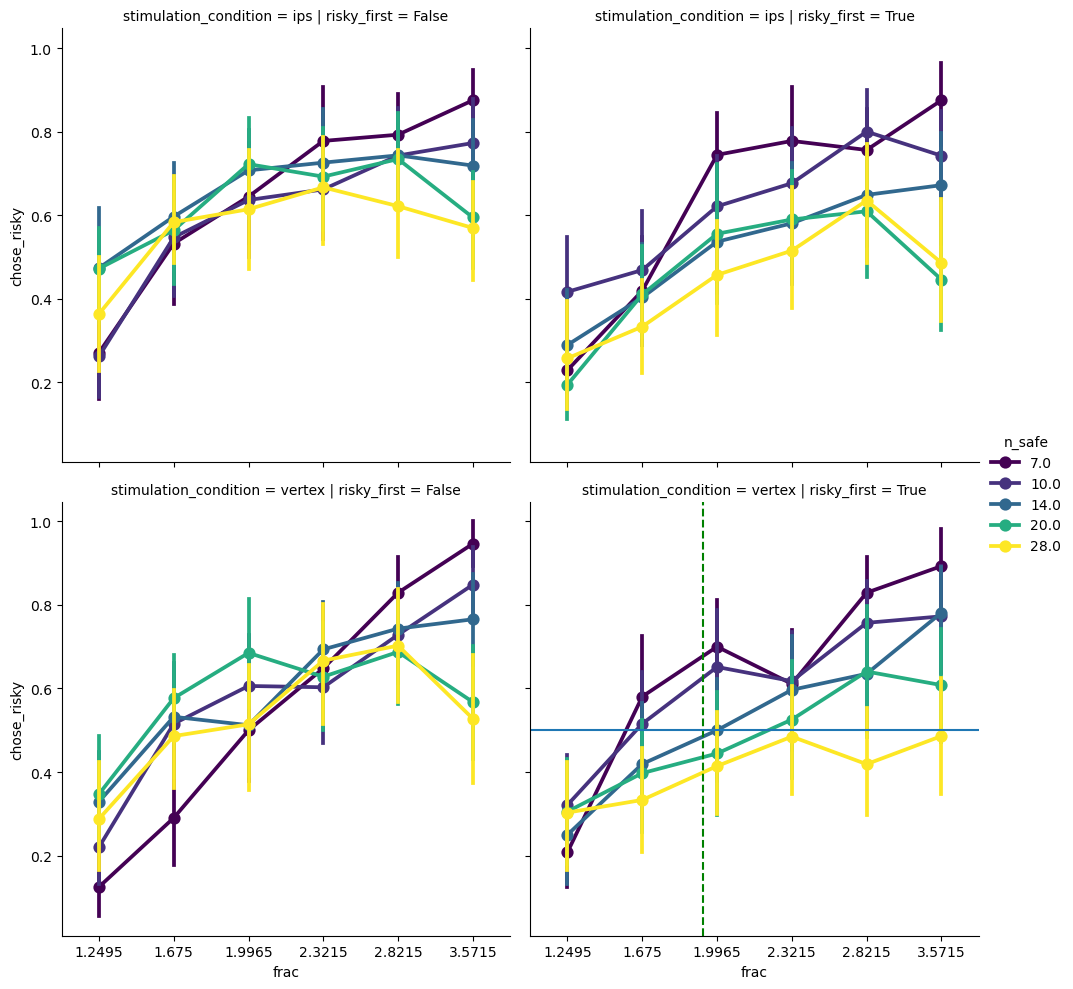

In [263]:


tmp = df.groupby(['subject', 'risky_first', 'stimulation_condition', 'frac', 'n_safe'])['chose_risky'].mean().reset_index()

tmp['frac'] = pd.qcut(tmp['frac'], 6).apply(lambda x: x.mid).astype(float)

sns.catplot(x='frac', y='chose_risky', hue='n_safe', row='stimulation_condition', col='risky_first', data=tmp, kind='point', palette='viridis')

plt.axvline(x=1./.55, c='green', ls='--')
plt.axhline(y=0.5)

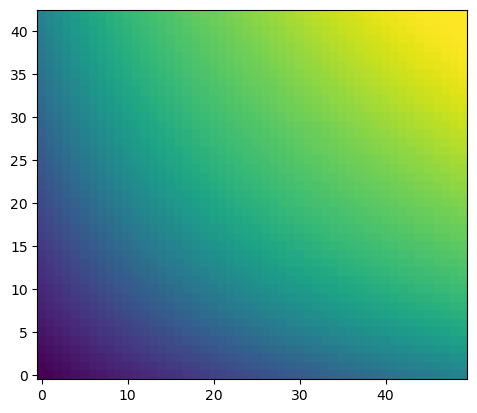

In [204]:
plt.imshow(risky_estimate_vertex, origin='lower')

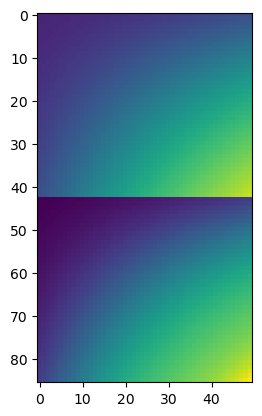

In [81]:
plt.imshow(risky_curves.groupby(['stimulation_condition', 'n_safe', 'frac']).mean()['n2_evidence_sd'].unstack('frac'))

In [ ]:
risky_curves.groupby(['stimulation_condition', 'x']).mean()['n1_evidence_sd']

stimulation_condition  x         
ips                    7.000000      1.929805
                       7.428571      1.947574
                       7.500000      1.950535
                       7.857143      1.965342
                       7.959184      1.969572
                                       ...   
vertex                 106.346939    7.475745
                       106.632653    7.494359
                       108.000000    7.586247
                       108.316327    7.608722
                       110.000000    7.731738
Name: n1_evidence_sd, Length: 3804, dtype: float64

In [56]:
risky_curves

variable                                  memory_noise_sd  \
subject stimulation_condition x                             
1       ips                   7.000000           0.781952   
                              7.428571           0.796248   
                              7.857143           0.810545   
                              8.285714           0.824782   
                              8.714286           0.838990   
...                                                   ...   
74      vertex                103.265306         2.244873   
                              104.948980         2.201523   
                              106.632653         2.153060   
                              108.316327         2.100182   
                              110.000000         2.043233   

variable                                  perceptual_noise_sd  n1_evidence_sd  \
subject stimulation_condition x                                                 
1       ips                   7.000000               0.746024        1.527976   
                              7.428571               0.755109        1.551358   
                              7.857143               0.764194        1.574739   
                              8.285714               0.773763        1.598545   
                              8.714286               0.783573        1.622563   
...                                                       ...             ...   
74      vertex                103.265306             3.136237        5.381111   
                              104.948980             2.968330        5.169853   
                              106.632653             2.799180        4.952239   
                              108.316327             2.632580        4.732763   
                              110.000000             2.471497        4.514730   

variable                                  n2_evidence_sd  all_noise  
subject stimulation_condition x                                      
1       ips                   7.000000          0.746024   1.714555  
                              7.428571          0.755109   1.739211  
                              7.857143          0.764194   1.763867  
                              8.285714          0.773763   1.789122  
                              8.714286          0.783573   1.814677  
...                                                  ...        ...  
74      vertex                103.265306        3.136237   6.245478  
                              104.948980        2.968330   5.983691  
                              106.632653        2.799180   5.717323  
                              108.316327        2.632580   5.451810  
                              110.000000        2.471497   5.191157  

[147000 rows x 5 columns]

In [35]:
interp1d?

Init signature:
interp1d(
    x,
    y,
    kind='linear',
    axis=-1,
    copy=True,
    bounds_error=None,
    fill_value=nan,
    assume_sorted=False,
)
Docstring:     
Interpolate a 1-D function (legacy).

.. legacy:: class

    For a guide to the intended replacements for `interp1d` see
    :ref:`tutorial-interpolate_1Dsection`.

`x` and `y` are arrays of values used to approximate some function f:
``y = f(x)``. This class returns a function whose call method uses
interpolation to find the value of new points.

Parameters
----------
x : (npoints, ) array_like
    A 1-D array of real values.
y : (..., npoints, ...) array_like
    A N-D array of real values. The length of `y` along the interpolation
    axis must be equal to the length of `x`. Use the ``axis`` parameter
    to select correct axis. Unlike other interpolators, the default
    interpolation axis is the last axis of `y`.
kind : str or int, optional
    Specifies the kind of interpolation as a string or as an integer
  

In [32]:
d.index

Index([  7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
       ...
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112],
      dtype='int64', name='x', length=106)

In [22]:
mean_curves

variable                           memory_noise_sd  perceptual_noise_sd  \
subject x   stimulation_condition                                         
1       7   ips                           0.781952             0.746024   
            vertex                        0.860939             0.381428   
        8   ips                           0.815311             0.767223   
            vertex                        0.899869             0.400844   
        9   ips                           0.848461             0.790113   
...                                            ...                  ...   
74      110 vertex                        2.043233             2.471497   
        111 ips                           2.318925             4.086631   
            vertex                        2.007549             2.379884   
        112 ips                           2.311701             4.046036   
            vertex                        1.970730             2.291778   

variable                           n1_evidence_sd  n2_evidence_sd  
subject x   stimulation_condition                                  
1       7   ips                          1.527976        0.746024  
            vertex                       1.242368        0.381428  
        8   ips                          1.582533        0.767223  
            vertex                       1.300713        0.400844  
        9   ips                          1.638575        0.790113  
...                                           ...             ...  
74      110 vertex                       4.514730        2.471497  
        111 ips                          6.405556        4.086631  
            vertex                       4.387432        2.379884  
        112 ips                          6.357736        4.046036  
            vertex                       4.262508        2.291778  

[7420 rows x 4 columns]

In [7]:
mean_curves

variable  subject    x stimulation_condition  memory_noise_sd  \
0               1    7                   ips         0.781952   
1               1    7                vertex         0.860939   
2               1    8                   ips         0.815311   
3               1    8                vertex         0.899869   
4               1    9                   ips         0.848461   
...           ...  ...                   ...              ...   
7415           74  110                vertex         2.043233   
7416           74  111                   ips         2.318925   
7417           74  111                vertex         2.007549   
7418           74  112                   ips         2.311701   
7419           74  112                vertex         1.970730   

variable  perceptual_noise_sd  n1_evidence_sd  n2_evidence_sd  
0                    0.746024        1.527976        0.746024  
1                    0.381428        1.242368        0.381428  
2                    0.767223        1.582533        0.767223  
3                    0.400844        1.300713        0.400844  
4                    0.790113        1.638575        0.790113  
...                       ...             ...             ...  
7415                 2.471497        4.514730        2.471497  
7416                 4.086631        6.405556        4.086631  
7417                 2.379884        4.387432        2.379884  
7418                 4.046036        6.357736        4.046036  
7419                 2.291778        4.262508        2.291778  

[7420 rows x 7 columns]